# BaselineML Model for Verification

# Sanity Check

For a quick sanity check, we can skip training and use random initialization to check pipeline.

✅ Extraction done!
Sample people folders: ['Daniel_Montenegro', 'Andrea_De_Cruz', 'Michael_Brandon', 'Cindy_Taylor', 'Brian_Billick', 'JT_Snow', 'Steve_Redgrave', 'Scott_Rudin', 'Mladen_Naletilic', 'Thomas_Enqvist']
Train samples: 2200, Test samples: 1000


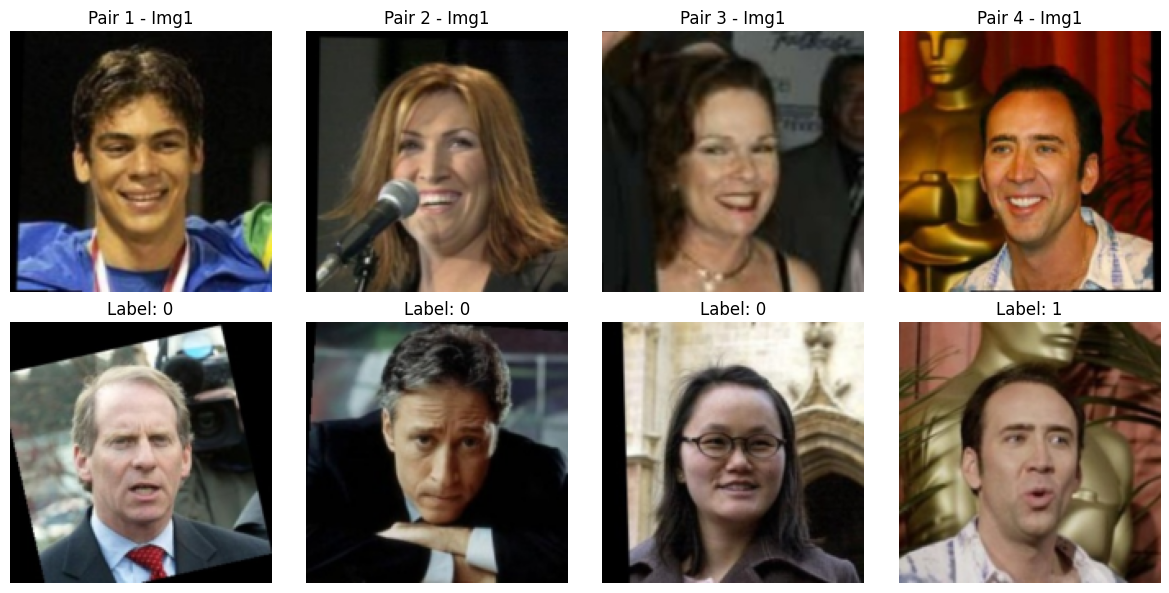

In [1]:
import os
import tarfile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ========================
# STEP 1: Extract dataset
# ========================
tgz_path = "/kaggle/input/lfwpeople/lfw-funneled.tgz"
extract_path = "/kaggle/working/lfw-funneled"

if not os.path.exists(extract_path):
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
    print("✅ Extraction done!")

base_dir = os.path.join(extract_path, "lfw_funneled")
print("Sample people folders:", os.listdir(base_dir)[:10])

# ========================
# STEP 2: Dataset class
# ========================
class LFWDataset(Dataset):
    def __init__(self, pairs_file, base_dir, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.pairs = []

        with open(pairs_file, "r") as f:
            lines = f.readlines()[1:]  # skip header line
            for line in lines:
                parts = line.strip().split("\t")
                if len(parts) == 3:  
                    # Same person: name id1 id2
                    name, id1, id2 = parts
                    path1 = os.path.join(base_dir, name, f"{name}_{int(id1):04d}.jpg")
                    path2 = os.path.join(base_dir, name, f"{name}_{int(id2):04d}.jpg")
                    self.pairs.append((path1, path2, 1))
                elif len(parts) == 4:  
                    # Different persons: name1 id1 name2 id2
                    name1, id1, name2, id2 = parts
                    path1 = os.path.join(base_dir, name1, f"{name1}_{int(id1):04d}.jpg")
                    path2 = os.path.join(base_dir, name2, f"{name2}_{int(id2):04d}.jpg")
                    self.pairs.append((path1, path2, 0))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path1, path2, label = self.pairs[idx]
        img1 = Image.open(path1).convert("RGB")
        img2 = Image.open(path2).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

# ========================
# STEP 3: Transform & Loaders
# ========================
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

train_pairs = "/kaggle/input/lfwpeople/pairsDevTrain.txt"
test_pairs  = "/kaggle/input/lfwpeople/pairsDevTest.txt"

train_dataset = LFWDataset(train_pairs, base_dir, transform=transform)
test_dataset  = LFWDataset(test_pairs, base_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ========================
# STEP 4: Visualization utility
# ========================
def show_sample_pairs(dataloader, n=4):
    imgs1, imgs2, labels = next(iter(dataloader))
    imgs1, imgs2, labels = imgs1[:n], imgs2[:n], labels[:n]

    plt.figure(figsize=(12, 6))
    for i in range(n):
        # First image
        plt.subplot(2, n, i+1)
        img1 = imgs1[i].permute(1, 2, 0).numpy()
        img1 = np.clip(img1, 0, 1)  # make sure values are in [0,1]
        #img1 = np.transpose(imgs1[i].numpy(), (1, 2, 0))
        plt.imshow(img1)
        plt.title(f"Pair {i+1} - Img1")
        plt.axis("off")

        # Second image
        plt.subplot(2, n, i+1+n)
        img2 = imgs2[i].permute(1, 2, 0).numpy()
        img2 = np.clip(img2, 0, 1)
        #img2 = np.transpose(imgs2[i].numpy(), (1, 2, 0))
        plt.imshow(img2)
        plt.title(f"Label: {int(labels[i].item())}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ========================
# STEP 5: Quick check
# ========================
show_sample_pairs(train_loader, n=4)


# Code with a Siamese baseline model + training loop.
This will give you a centralized baseline accuracy on LFW pairs (what Phase 1 needs).

What this does?

Uses ResNet18 backbone to extract embeddings.

Concatenates embeddings of two faces → predicts similarity (same/different).

Trains with binary cross-entropy (BCE).

Runs for 3 epochs (baseline check).

Sample people folders: ['Daniel_Montenegro', 'Andrea_De_Cruz', 'Michael_Brandon', 'Cindy_Taylor', 'Brian_Billick', 'JT_Snow', 'Steve_Redgrave', 'Scott_Rudin', 'Mladen_Naletilic', 'Thomas_Enqvist']
Train samples: 2200, Test samples: 1000


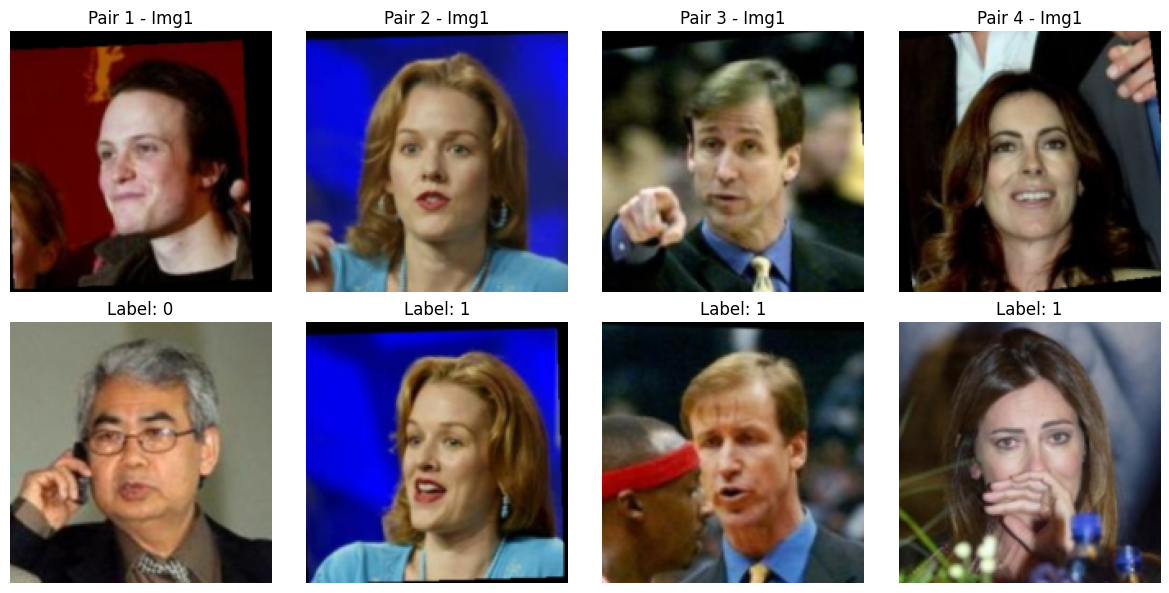

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.3MB/s]


Epoch 1/3: Train Loss=0.6975, Train Acc=0.5514, Test Loss=0.6931, Test Acc=0.5450
Epoch 2/3: Train Loss=0.3453, Train Acc=0.9000, Test Loss=0.8278, Test Acc=0.5410
Epoch 3/3: Train Loss=0.1174, Train Acc=0.9695, Test Loss=0.9818, Test Acc=0.5590


In [2]:
import os
import tarfile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ========================
# STEP 1: Extract dataset
# ========================
tgz_path = "/kaggle/input/lfwpeople/lfw-funneled.tgz"
extract_path = "/kaggle/working/lfw-funneled"

if not os.path.exists(extract_path):
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
    print("✅ Extraction done!")

base_dir = os.path.join(extract_path, "lfw_funneled")
print("Sample people folders:", os.listdir(base_dir)[:10])

# ========================
# STEP 2: Dataset class
# ========================
class LFWDataset(Dataset):
    def __init__(self, pairs_file, base_dir, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.pairs = []

        with open(pairs_file, "r") as f:
            lines = f.readlines()[1:]  # skip header
            for line in lines:
                parts = line.strip().split("\t")
                if len(parts) == 3:  
                    # Same person
                    name, id1, id2 = parts
                    path1 = os.path.join(base_dir, name, f"{name}_{int(id1):04d}.jpg")
                    path2 = os.path.join(base_dir, name, f"{name}_{int(id2):04d}.jpg")
                    self.pairs.append((path1, path2, 1))
                elif len(parts) == 4:  
                    # Different persons
                    name1, id1, name2, id2 = parts
                    path1 = os.path.join(base_dir, name1, f"{name1}_{int(id1):04d}.jpg")
                    path2 = os.path.join(base_dir, name2, f"{name2}_{int(id2):04d}.jpg")
                    self.pairs.append((path1, path2, 0))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path1, path2, label = self.pairs[idx]
        img1 = Image.open(path1).convert("RGB")
        img2 = Image.open(path2).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

# ========================
# STEP 3: Transform & Loaders
# ========================
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

train_pairs = "/kaggle/input/lfwpeople/pairsDevTrain.txt"
test_pairs  = "/kaggle/input/lfwpeople/pairsDevTest.txt"

train_dataset = LFWDataset(train_pairs, base_dir, transform=transform)
test_dataset  = LFWDataset(test_pairs, base_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ========================
# STEP 4: Visualization utility
# ========================
def show_sample_pairs(dataloader, n=4):
    imgs1, imgs2, labels = next(iter(dataloader))
    imgs1, imgs2, labels = imgs1[:n], imgs2[:n], labels[:n]

    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        img1 = imgs1[i].permute(1, 2, 0).numpy()
        plt.imshow(np.clip(img1, 0, 1))
        plt.title(f"Pair {i+1} - Img1")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        img2 = imgs2[i].permute(1, 2, 0).numpy()
        plt.imshow(np.clip(img2, 0, 1))
        plt.title(f"Label: {int(labels[i].item())}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Quick sanity check
show_sample_pairs(train_loader, n=4)

# ========================
# STEP 5: Siamese Baseline Model
# ========================
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        # Use pretrained ResNet18 backbone
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        backbone.fc = nn.Linear(backbone.fc.in_features, embedding_dim)
        self.backbone = backbone

    def forward(self, x):
        return self.backbone(x)

class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net
        self.fc = nn.Linear(embedding_net.backbone.fc.out_features * 2, 1)

    def forward(self, x1, x2):
        e1 = self.embedding_net(x1)
        e2 = self.embedding_net(x2)
        combined = torch.cat([e1, e2], dim=1)
        out = torch.sigmoid(self.fc(combined))
        return out

# ========================
# STEP 6: Training
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for img1, img2, labels in loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(img1, img2).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for img1, img2, labels in loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2).squeeze()
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

# Train for a few epochs (baseline)
epochs = 3
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")


Sample people folders: ['Daniel_Montenegro', 'Andrea_De_Cruz', 'Michael_Brandon', 'Cindy_Taylor', 'Brian_Billick', 'JT_Snow', 'Steve_Redgrave', 'Scott_Rudin', 'Mladen_Naletilic', 'Thomas_Enqvist']
Train samples: 2200, Test samples: 1000


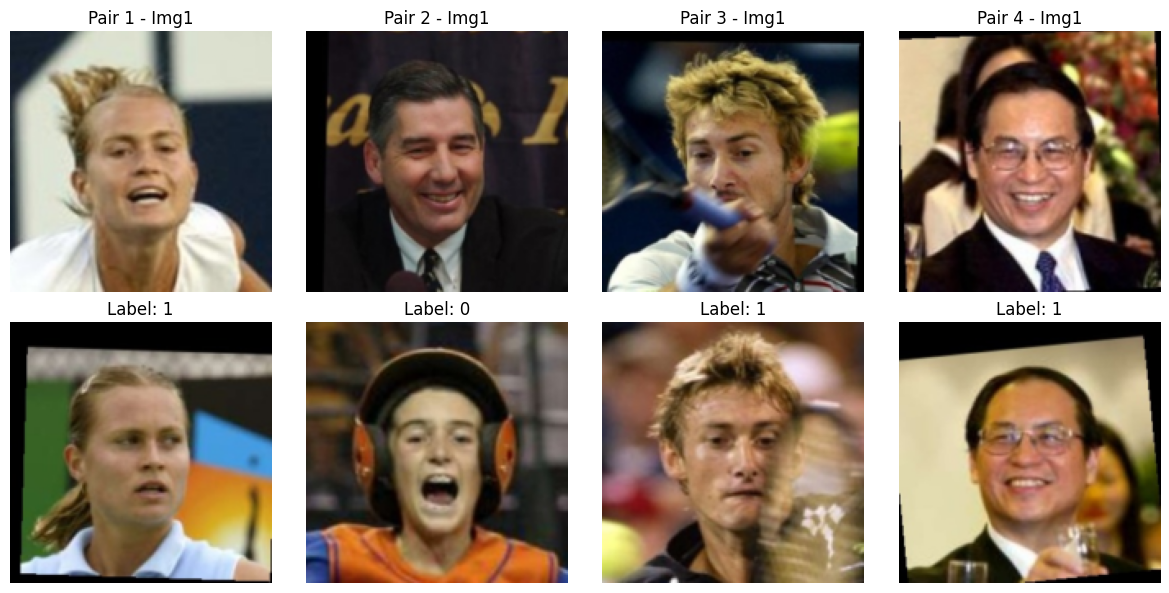

Using device: cuda
Estimated centralized upload bandwidth: 1289.06 MB
Epoch 1/3 | Train Loss=0.6898, Train Acc=0.5573 | Test Loss=0.6861, Test Acc=0.5610 | Time: 19.26s | Max GPU Mem: 923.83154296875 MB
Epoch 2/3 | Train Loss=0.3380, Train Acc=0.8941 | Test Loss=0.8417, Test Acc=0.5340 | Time: 18.73s | Max GPU Mem: 923.83154296875 MB
Epoch 3/3 | Train Loss=0.1120, Train Acc=0.9718 | Test Loss=1.0007, Test Acc=0.5290 | Time: 18.44s | Max GPU Mem: 923.83154296875 MB


In [4]:
import os
import tarfile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time

# ========================
# STEP 1: Extract dataset
# ========================
tgz_path = "/kaggle/input/lfwpeople/lfw-funneled.tgz"
extract_path = "/kaggle/working/lfw-funneled"

if not os.path.exists(extract_path):
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
    print("✅ Extraction done!")

base_dir = os.path.join(extract_path, "lfw_funneled")
print("Sample people folders:", os.listdir(base_dir)[:10])

# ========================
# STEP 2: Dataset class
# ========================
class LFWDataset(Dataset):
    def __init__(self, pairs_file, base_dir, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.pairs = []

        with open(pairs_file, "r") as f:
            lines = f.readlines()[1:]  # skip header
            for line in lines:
                parts = line.strip().split("\t")
                if len(parts) == 3:  
                    name, id1, id2 = parts
                    path1 = os.path.join(base_dir, name, f"{name}_{int(id1):04d}.jpg")
                    path2 = os.path.join(base_dir, name, f"{name}_{int(id2):04d}.jpg")
                    self.pairs.append((path1, path2, 1))
                elif len(parts) == 4:  
                    name1, id1, name2, id2 = parts
                    path1 = os.path.join(base_dir, name1, f"{name1}_{int(id1):04d}.jpg")
                    path2 = os.path.join(base_dir, name2, f"{name2}_{int(id2):04d}.jpg")
                    self.pairs.append((path1, path2, 0))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path1, path2, label = self.pairs[idx]
        img1 = Image.open(path1).convert("RGB")
        img2 = Image.open(path2).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

# ========================
# STEP 3: Transform & Loaders
# ========================
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

train_pairs = "/kaggle/input/lfwpeople/pairsDevTrain.txt"
test_pairs  = "/kaggle/input/lfwpeople/pairsDevTest.txt"

train_dataset = LFWDataset(train_pairs, base_dir, transform=transform)
test_dataset  = LFWDataset(test_pairs, base_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ========================
# STEP 4: Visualization utility
# ========================
def show_sample_pairs(dataloader, n=4):
    imgs1, imgs2, labels = next(iter(dataloader))
    imgs1, imgs2, labels = imgs1[:n], imgs2[:n], labels[:n]

    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        img1 = imgs1[i].permute(1, 2, 0).numpy()
        plt.imshow(np.clip(img1, 0, 1))
        plt.title(f"Pair {i+1} - Img1")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        img2 = imgs2[i].permute(1, 2, 0).numpy()
        plt.imshow(np.clip(img2, 0, 1))
        plt.title(f"Label: {int(labels[i].item())}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Quick sanity check
show_sample_pairs(train_loader, n=4)

# ========================
# STEP 5: Siamese Baseline Model
# ========================
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        backbone.fc = nn.Linear(backbone.fc.in_features, embedding_dim)
        self.backbone = backbone

    def forward(self, x):
        return self.backbone(x)

class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net
        self.fc = nn.Linear(embedding_net.backbone.fc.out_features * 2, 1)

    def forward(self, x1, x2):
        e1 = self.embedding_net(x1)
        e2 = self.embedding_net(x2)
        combined = torch.cat([e1, e2], dim=1)
        out = torch.sigmoid(self.fc(combined))
        return out

# ========================
# STEP 6: Training setup
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ========================
# STEP 7: Train + Eval with logging
# ========================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for img1, img2, labels in loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(img1, img2).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for img1, img2, labels in loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2).squeeze()
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

# ========================
# STEP 8: Bandwidth estimation (centralized)
# ========================
def estimate_bandwidth(loader):
    total_bytes = 0
    for img1, img2, _ in loader:
        total_bytes += img1.numel() * img1.element_size()
        total_bytes += img2.numel() * img2.element_size()
    return total_bytes / (1024 ** 2)  # MB

centralized_bandwidth_MB = estimate_bandwidth(train_loader)
print(f"Estimated centralized upload bandwidth: {centralized_bandwidth_MB:.2f} MB")

# ========================
# STEP 9: Train Loop with logging
# ========================
epochs = 3
for epoch in range(epochs):
    start_time = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    epoch_time = time.time() - start_time
    if device.type == "cuda":
        max_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # MB
        torch.cuda.reset_peak_memory_stats(device)
    else:
        max_memory = "N/A"

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f} | "
          f"Time: {epoch_time:.2f}s | Max GPU Mem: {max_memory} MB")


# Federated Learning 

In [5]:
import copy
import random
import time

# ========================
# STEP 1: FL Simulation Setup
# ========================

NUM_USERS = 5      # Number of simulated clients
ROUNDS = 3         # FL communication rounds
LOCAL_EPOCHS = 1   # Epochs per user per round

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Function to split dataset non-IID among users
def split_dataset(dataset, num_users):
    """Return a dict: {user_id: SubsetDataset}"""
    user_data = {i: [] for i in range(num_users)}
    # Group indices by person
    person_to_indices = {}
    for idx in range(len(dataset)):
        path1, path2, label = dataset.pairs[idx]
        person = os.path.basename(path1).split("_")[0]
        if person not in person_to_indices:
            person_to_indices[person] = []
        person_to_indices[person].append(idx)
    # Shuffle and assign people to users
    people = list(person_to_indices.keys())
    random.shuffle(people)
    for i, person in enumerate(people):
        user_id = i % num_users
        user_data[user_id].extend(person_to_indices[person])
    # Create Subset Datasets
    user_datasets = {i: torch.utils.data.Subset(dataset, user_data[i]) for i in range(num_users)}
    return user_datasets

# Split train dataset among users
user_train_datasets = split_dataset(train_dataset, NUM_USERS)
user_train_loaders = {i: DataLoader(ds, batch_size=32, shuffle=True) for i, ds in user_train_datasets.items()}

# ========================
# STEP 2: Initialize Global Model
# ========================
global_model = SiameseNet(EmbeddingNet()).to(device)
global_model.train()

# ========================
# STEP 3: Federated Training
# ========================
for round_num in range(1, ROUNDS + 1):
    print(f"\n--- FL Round {round_num}/{ROUNDS} ---")
    round_start = time.time()

    local_models = []
    local_times = []
    local_memories = []

    for user_id in range(NUM_USERS):
        # Clone global model
        local_model = copy.deepcopy(global_model).to(device)
        local_model.train()
        optimizer = optim.Adam(local_model.parameters(), lr=1e-4)

        # Train locally
        start_time = time.time()
        for epoch in range(LOCAL_EPOCHS):
            train_loss, train_acc = train_one_epoch(local_model, user_train_loaders[user_id], optimizer, criterion, device)
        epoch_time = time.time() - start_time
        local_times.append(epoch_time)

        # Track GPU memory
        if device.type == "cuda":
            max_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            torch.cuda.reset_peak_memory_stats(device)
        else:
            max_memory = "N/A"
        local_memories.append(max_memory)

        print(f"User {user_id}: Local Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, Time={epoch_time:.2f}s, Mem={max_memory}MB")

        local_models.append(local_model.state_dict())

    # ========================
    # Step 4: FedAvg Aggregation
    # ========================
    global_dict = global_model.state_dict()
    # Initialize
    for key in global_dict.keys():
        global_dict[key] = torch.stack([local_models[i][key].float() for i in range(NUM_USERS)], 0).mean(0)
    global_model.load_state_dict(global_dict)

    # ========================
    # Step 5: Evaluate Global Model
    # ========================
    test_loss, test_acc = evaluate(global_model, test_loader, criterion, device)
    round_time = time.time() - round_start

    # ========================
    # Step 6: Bandwidth Estimation
    # ========================
    # Each user sends model parameters per round
    model_bytes = sum(p.numel() * p.element_size() for p in global_model.parameters())  # bytes per user
    total_bytes = model_bytes * NUM_USERS / (1024 ** 2)  # MB
    bandwidth_saving = (centralized_bandwidth_MB - total_bytes) / centralized_bandwidth_MB * 100

    print(f"Round {round_num} Global Test Loss={test_loss:.4f}, Acc={test_acc:.4f}")
    print(f"Round Time: {round_time:.2f}s | Peak Memory per user: {max(local_memories)} MB")
    print(f"Bandwidth per round: {total_bytes:.2f} MB | Savings vs centralized: {bandwidth_saving:.2f}%")


Using device: cuda

--- FL Round 1/3 ---
User 0: Local Train Loss=0.6750, Acc=0.5700, Time=2.85s, Mem=1054.62939453125MB
User 1: Local Train Loss=0.6822, Acc=0.5558, Time=3.18s, Mem=1099.66162109375MB
User 2: Local Train Loss=0.6823, Acc=0.5613, Time=3.46s, Mem=1143.66650390625MB
User 3: Local Train Loss=0.6891, Acc=0.5518, Time=2.89s, Mem=1191.03857421875MB
User 4: Local Train Loss=0.6968, Acc=0.5288, Time=2.78s, Mem=1236.52783203125MB
Round 1 Global Test Loss=0.6931, Acc=0.5340
Round Time: 19.39s | Peak Memory per user: 1236.52783203125 MB
Bandwidth per round: 214.43 MB | Savings vs centralized: 83.37%

--- FL Round 2/3 ---
User 0: Local Train Loss=0.5713, Acc=0.7391, Time=2.84s, Mem=1102.59912109375MB
User 1: Local Train Loss=0.5991, Acc=0.6910, Time=3.15s, Mem=1149.91259765625MB
User 2: Local Train Loss=0.6103, Acc=0.7095, Time=3.41s, Mem=1193.85107421875MB
User 3: Local Train Loss=0.6231, Acc=0.6506, Time=2.78s, Mem=1237.06298828125MB
User 4: Local Train Loss=0.6184, Acc=0.6792, T

# visualizations to track FL progress across rounds


--- FL Round 1/3 ---
User 0: Local Train Loss=0.3977, Acc=0.8406, Time=2.79s, Mem=1105.29443359375MB
User 1: Local Train Loss=0.4116, Acc=0.8519, Time=3.08s, Mem=1150.05322265625MB
User 2: Local Train Loss=0.4135, Acc=0.8735, Time=3.38s, Mem=1191.41748046875MB
User 3: Local Train Loss=0.4385, Acc=0.8458, Time=2.78s, Mem=1232.84814453125MB
User 4: Local Train Loss=0.4576, Acc=0.8596, Time=2.69s, Mem=1276.20458984375MB
Round 1 Global Test Loss=0.7243, Acc=0.5500
Round Time: 19.14s | Peak Memory per user: 1276.20458984375 MB
Bandwidth per round: 214.43 MB | Savings vs centralized: 83.37%

--- FL Round 2/3 ---
User 0: Local Train Loss=0.2883, Acc=0.9130, Time=2.79s, Mem=1099.88037109375MB
User 1: Local Train Loss=0.3349, Acc=0.8970, Time=3.18s, Mem=1146.67041015625MB
User 2: Local Train Loss=0.3460, Acc=0.8893, Time=3.49s, Mem=1191.88232421875MB
User 3: Local Train Loss=0.3218, Acc=0.8940, Time=2.83s, Mem=1235.44580078125MB
User 4: Local Train Loss=0.3315, Acc=0.8897, Time=2.82s, Mem=1279

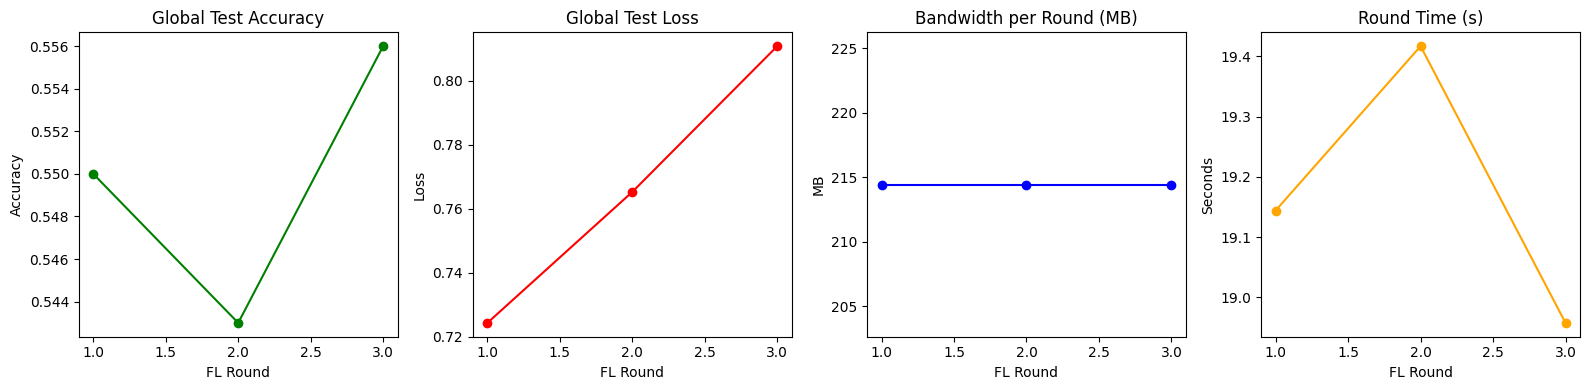

In [6]:
import matplotlib.pyplot as plt

# ========================
# STEP 7: Initialize logging lists
# ========================
round_nums = []
global_test_accs = []
global_test_losses = []
bandwidths_MB = []
round_times = []

# ========================
# STEP 3-6: Federated Training Loop (with logging)
# ========================
for round_num in range(1, ROUNDS + 1):
    print(f"\n--- FL Round {round_num}/{ROUNDS} ---")
    round_start = time.time()

    local_models = []
    local_times = []
    local_memories = []

    for user_id in range(NUM_USERS):
        # Clone global model
        local_model = copy.deepcopy(global_model).to(device)
        local_model.train()
        optimizer = optim.Adam(local_model.parameters(), lr=1e-4)

        # Train locally
        start_time = time.time()
        for epoch in range(LOCAL_EPOCHS):
            train_loss, train_acc = train_one_epoch(local_model, user_train_loaders[user_id], optimizer, criterion, device)
        epoch_time = time.time() - start_time
        local_times.append(epoch_time)

        # Track GPU memory
        if device.type == "cuda":
            max_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            torch.cuda.reset_peak_memory_stats(device)
        else:
            max_memory = "N/A"
        local_memories.append(max_memory)

        print(f"User {user_id}: Local Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, Time={epoch_time:.2f}s, Mem={max_memory}MB")

        local_models.append(local_model.state_dict())

    # ========================
    # Step 4: FedAvg Aggregation
    # ========================
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([local_models[i][key].float() for i in range(NUM_USERS)], 0).mean(0)
    global_model.load_state_dict(global_dict)

    # ========================
    # Step 5: Evaluate Global Model
    # ========================
    test_loss, test_acc = evaluate(global_model, test_loader, criterion, device)
    round_time = time.time() - round_start

    # ========================
    # Step 6: Bandwidth Estimation
    # ========================
    model_bytes = sum(p.numel() * p.element_size() for p in global_model.parameters())
    total_bytes = model_bytes * NUM_USERS / (1024 ** 2)  # MB
    bandwidth_saving = (centralized_bandwidth_MB - total_bytes) / centralized_bandwidth_MB * 100

    print(f"Round {round_num} Global Test Loss={test_loss:.4f}, Acc={test_acc:.4f}")
    print(f"Round Time: {round_time:.2f}s | Peak Memory per user: {max(local_memories)} MB")
    print(f"Bandwidth per round: {total_bytes:.2f} MB | Savings vs centralized: {bandwidth_saving:.2f}%")

    # ========================
    # Logging for plots
    # ========================
    round_nums.append(round_num)
    global_test_accs.append(test_acc)
    global_test_losses.append(test_loss)
    bandwidths_MB.append(total_bytes)
    round_times.append(round_time)

# ========================
# STEP 8: Plot FL metrics
# ========================
plt.figure(figsize=(16, 4))

# Accuracy
plt.subplot(1, 4, 1)
plt.plot(round_nums, global_test_accs, marker='o', color='green')
plt.title("Global Test Accuracy")
plt.xlabel("FL Round")
plt.ylabel("Accuracy")

# Loss
plt.subplot(1, 4, 2)
plt.plot(round_nums, global_test_losses, marker='o', color='red')
plt.title("Global Test Loss")
plt.xlabel("FL Round")
plt.ylabel("Loss")

# Bandwidth
plt.subplot(1, 4, 3)
plt.plot(round_nums, bandwidths_MB, marker='o', color='blue')
plt.title("Bandwidth per Round (MB)")
plt.xlabel("FL Round")
plt.ylabel("MB")

# Round Time
plt.subplot(1, 4, 4)
plt.plot(round_nums, round_times, marker='o', color='orange')
plt.title("Round Time (s)")
plt.xlabel("FL Round")
plt.ylabel("Seconds")

plt.tight_layout()
plt.show()


✅ Extracted lfw-funneled.tgz
Image root: /kaggle/working/lfw-funneled/lfw_funneled
Train pairs: /kaggle/input/lfwpeople/pairsDevTrain.txt
Test pairs: /kaggle/input/lfwpeople/pairsDevTest.txt
Loaded train/test: 2200 1000
Estimated centralized upload (raw train images): 1289.06 MB
Device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s] 



=== Centralized training (full dataset) ===
Central Epoch 1/3 | Train Loss=0.6866, Train Acc=0.5509 | Test Loss=0.6800, Test Acc=0.5630 | Time=13.28s | PeakMem=923.34814453125 MB
Central Epoch 2/3 | Train Loss=0.5701, Train Acc=0.8327 | Test Loss=0.6934, Test Acc=0.5380 | Time=10.51s | PeakMem=923.34814453125 MB
Central Epoch 3/3 | Train Loss=0.4301, Train Acc=0.9550 | Test Loss=0.7078, Test Acc=0.5170 | Time=10.56s | PeakMem=923.34814453125 MB
Centralized total train time: 34.35s | Peak GPU mem: 923.34814453125 MB | Raw image upload: 1289.06 MB
User 0 -> local train pairs: 352, local val pairs: 89
User 1 -> local train pairs: 353, local val pairs: 89
User 2 -> local train pairs: 358, local val pairs: 90
User 3 -> local train pairs: 354, local val pairs: 89
User 4 -> local train pairs: 340, local val pairs: 86
Model size: 42.89 MB (for weight transfer estimates)

=== Federated Training Simulation ===
Round 1 | User 0 local train loss=0.6891, train acc=0.5256, local val acc=0.4157, tim

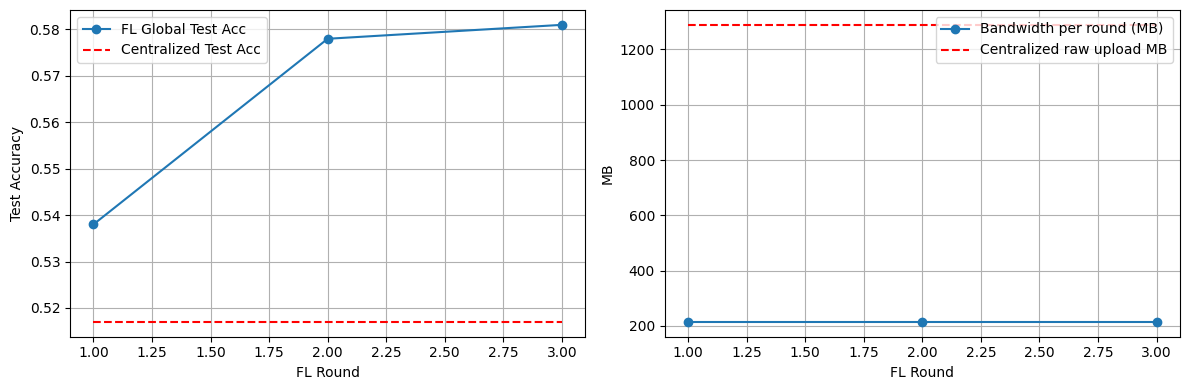

In [1]:
# Full centralized vs federated simulation cell (drop-in)
import os, tarfile, time, copy, random, gc
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image

# -------------------------
# CONFIG
# -------------------------
NUM_USERS = 5
ROUNDS = 3
LOCAL_EPOCHS = 1     # epochs per user per round in FL
CENTRAL_EPOCHS = 3   # epochs for centralized training
BATCH_SIZE = 32
IMG_SIZE = 160
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------------------------
# STEP 0: Paths & extract LFW if needed
# -------------------------
INPUT_DIR = "/kaggle/input/lfwpeople"
TGZ_PATH = os.path.join(INPUT_DIR, "lfw-funneled.tgz")
EXTRACT_PATH = "/kaggle/working/lfw-funneled"

if not os.path.exists(EXTRACT_PATH):
    with tarfile.open(TGZ_PATH, "r:gz") as tar:
        tar.extractall(path=EXTRACT_PATH)
    print("✅ Extracted lfw-funneled.tgz")

IMG_ROOT = os.path.join(EXTRACT_PATH, "lfw_funneled")
TRAIN_PAIRS = os.path.join(INPUT_DIR, "pairsDevTrain.txt")
TEST_PAIRS  = os.path.join(INPUT_DIR, "pairsDevTest.txt")

assert os.path.exists(IMG_ROOT), f"Image root not found: {IMG_ROOT}"
print("Image root:", IMG_ROOT)
print("Train pairs:", TRAIN_PAIRS)
print("Test pairs:", TEST_PAIRS)

# -------------------------
# STEP 1: LFW pairs Dataset (uses official pairs files)
# -------------------------
class LFWDatasetPairs(Dataset):
    def __init__(self, pairs_file, img_root, transform=None):
        self.img_root = img_root
        self.transform = transform
        self.pairs = []
        with open(pairs_file, "r") as f:
            lines = f.readlines()[1:]
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:
                name, i1, i2 = parts
                p1 = os.path.join(img_root, name, f"{name}_{int(i1):04d}.jpg")
                p2 = os.path.join(img_root, name, f"{name}_{int(i2):04d}.jpg")
                self.pairs.append((p1, p2, 1))
            elif len(parts) == 4:
                n1, i1, n2, i2 = parts
                p1 = os.path.join(img_root, n1, f"{n1}_{int(i1):04d}.jpg")
                p2 = os.path.join(img_root, n2, f"{n2}_{int(i2):04d}.jpg")
                self.pairs.append((p1, p2, 0))
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        p1, p2, label = self.pairs[idx]
        img1 = Image.open(p1).convert("RGB")
        img2 = Image.open(p2).convert("RGB")
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(label, dtype=torch.float32)

# transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataset = LFWDatasetPairs(TRAIN_PAIRS, IMG_ROOT, transform=transform)
test_dataset  = LFWDatasetPairs(TEST_PAIRS, IMG_ROOT, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Loaded train/test:", len(train_dataset), len(test_dataset))

# -------------------------
# Utility: estimate centralized upload bandwidth (raw images)
# -------------------------
def estimate_image_bandwidth(loader):
    total_bytes = 0
    for x1, x2, _ in loader:
        total_bytes += x1.numel() * x1.element_size()
        total_bytes += x2.numel() * x2.element_size()
    return total_bytes / (1024**2)  # MB

centralized_upload_MB = estimate_image_bandwidth(train_loader)
print(f"Estimated centralized upload (raw train images): {centralized_upload_MB:.2f} MB")

# -------------------------
# STEP 2: Simple Siamese model with ResNet18 backbone
# -------------------------
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        backbone.fc = nn.Linear(backbone.fc.in_features, embedding_dim)
        self.backbone = backbone
    def forward(self, x):
        return F.normalize(self.backbone(x), p=2, dim=1)

class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net
        self.fc = nn.Linear(embedding_net.backbone.fc.out_features * 2, 1)
    def forward(self, x1, x2):
        e1 = self.embedding_net(x1)
        e2 = self.embedding_net(x2)
        comb = torch.cat([e1, e2], dim=1)
        return torch.sigmoid(self.fc(comb))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Training / Evaluation helpers
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for x1, x2, y in loader:
        x1 = x1.to(device); x2 = x2.to(device); y = y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        out = model(x1, x2)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds = (out > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x1, x2, y in loader:
            x1 = x1.to(device); x2 = x2.to(device); y = y.to(device).unsqueeze(1)
            out = model(x1, x2)
            loss = criterion(out, y)
            total_loss += loss.item() * y.size(0)
            preds = (out > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)
    return total_loss / total, correct / total

# -------------------------
# STEP 3: Centralized training baseline (train on full train_loader)
# -------------------------
central_model = SiameseNet(EmbeddingNet()).to(device)
criterion = nn.BCELoss()
opt = optim.Adam(central_model.parameters(), lr=1e-4)

print("\n=== Centralized training (full dataset) ===")
central_start = time.time()
epoch_times = []
torch.cuda.reset_peak_memory_stats(device) if device.type=='cuda' else None

for e in range(1, CENTRAL_EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(central_model, train_loader, opt, criterion, device)
    val_loss, val_acc = evaluate_model(central_model, test_loader, criterion, device)
    t_epoch = time.time() - t0
    epoch_times.append(t_epoch)
    peak_mem = torch.cuda.max_memory_allocated(device)/(1024**2) if device.type=='cuda' else None
    print(f"Central Epoch {e}/{CENTRAL_EPOCHS} | Train Loss={tr_loss:.4f}, Train Acc={tr_acc:.4f} | Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f} | Time={t_epoch:.2f}s | PeakMem={peak_mem} MB")

central_total_time = time.time() - central_start
central_peak_mem = torch.cuda.max_memory_allocated(device)/(1024**2) if device.type=='cuda' else None

# estimate centralized upload bandwidth (we already computed image upload)
print(f"Centralized total train time: {central_total_time:.2f}s | Peak GPU mem: {central_peak_mem} MB | Raw image upload: {centralized_upload_MB:.2f} MB")

# -------------------------
# STEP 4: FL simulation prep (non-IID split among users)
#    We split train_dataset indices by person name and assign people to users,
#    then create a per-user train/test split (80/20) inside assigned indices.
# -------------------------
def split_train_dataset_non_iid(dataset_pairs, num_users, per_user_ratio=0.8):
    # dataset_pairs.pairs entries hold (path1, path2, label)
    person_to_indices = {}
    for idx in range(len(dataset_pairs)):
        p1, p2, lbl = dataset_pairs.pairs[idx]
        # derive person's folder from p1 (same person or first person of pair)
        person = os.path.basename(p1).rsplit('_', 1)[0]  # full name
        if person not in person_to_indices:
            person_to_indices[person] = []
        person_to_indices[person].append(idx)
    people = list(person_to_indices.keys())
    random.shuffle(people)
    user_indices = {u: [] for u in range(num_users)}
    for i, person in enumerate(people):
        user = i % num_users
        user_indices[user].extend(person_to_indices[person])
    # Now split each user's indices into local train and local val (80/20)
    user_loaders = {}
    user_val_loaders = {}
    for u in range(num_users):
        inds = user_indices[u]
        random.shuffle(inds)
        cut = int(len(inds)*per_user_ratio)
        train_inds = inds[:cut] if cut>0 else inds
        val_inds = inds[cut:] if cut>0 else []
        user_train = Subset(dataset_pairs, train_inds)
        user_val   = Subset(dataset_pairs, val_inds) if len(val_inds)>0 else Subset(dataset_pairs, train_inds)
        user_loaders[u] = DataLoader(user_train, batch_size=BATCH_SIZE, shuffle=True)
        user_val_loaders[u] = DataLoader(user_val, batch_size=BATCH_SIZE, shuffle=False)
    return user_loaders, user_val_loaders

user_train_loaders, user_val_loaders = split_train_dataset_non_iid(train_dataset, NUM_USERS)
for u in range(NUM_USERS):
    # print sizes
    tr_size = sum(1 for _ in user_train_loaders[u].dataset)
    val_size = sum(1 for _ in user_val_loaders[u].dataset)
    print(f"User {u} -> local train pairs: {tr_size}, local val pairs: {val_size}")

# -------------------------
# STEP 5: Federated Training (FedAvg)
# -------------------------
def get_model_num_bytes(model):
    return sum(p.numel() * p.element_size() for p in model.parameters())  # bytes

global_model = SiameseNet(EmbeddingNet()).to(device)
global_model.train()
model_bytes = get_model_num_bytes(global_model)
model_MB = model_bytes / (1024**2)
print(f"Model size: {model_MB:.2f} MB (for weight transfer estimates)")

# logging containers
fl_rounds = []
fl_global_train_accs = []
fl_global_test_accs = []
fl_global_train_losses = []
fl_global_test_losses = []
fl_bandwidth_MB = []
fl_round_times = []
fl_peak_mems = []

criterion = nn.BCELoss()

print("\n=== Federated Training Simulation ===")
for r in range(1, ROUNDS+1):
    r_start = time.time()
    local_states = []
    local_stats = []
    local_peak = 0.0

    for u in range(NUM_USERS):
        # copy global model to local
        local_model = copy.deepcopy(global_model).to(device)
        local_opt = optim.Adam(local_model.parameters(), lr=1e-4)

        # local training
        t0 = time.time()
        for le in range(LOCAL_EPOCHS):
            l_loss, l_acc = train_one_epoch(local_model, user_train_loaders[u], local_opt, criterion, device)
        t_local = time.time() - t0
        # local eval on user's local val (personalization)
        local_val_loss, local_val_acc = evaluate_model(local_model, user_val_loaders[u], criterion, device)

        # record
        local_states.append(copy.deepcopy(local_model.state_dict()))
        local_stats.append((l_loss, l_acc, local_val_loss, local_val_acc, t_local))

        # memory
        mem = torch.cuda.max_memory_allocated(device)/(1024**2) if device.type=='cuda' else None
        local_peak = max(local_peak, mem if mem is not None else 0.0)

        print(f"Round {r} | User {u} local train loss={l_loss:.4f}, train acc={l_acc:.4f}, local val acc={local_val_acc:.4f}, time={t_local:.2f}s, peakMem={mem}MB")

        # cleanup local model to free memory
        del local_model; gc.collect(); torch.cuda.empty_cache()

    # FedAvg: average state_dicts
    new_state = copy.deepcopy(local_states[0])
    for k in new_state.keys():
        # stack then mean
        stacked = torch.stack([local_states[i][k].float().cpu() for i in range(len(local_states))], dim=0)
        new_state[k] = torch.mean(stacked, dim=0).to(device)
    global_model.load_state_dict(new_state)

    # Evaluate global model on centralized train and test sets
    gtrain_loss, gtrain_acc = evaluate_model(global_model, train_loader, criterion, device)
    gtest_loss,  gtest_acc  = evaluate_model(global_model, test_loader, criterion, device)

    r_time = time.time() - r_start
    # bandwidth per round: each user sends their model (upload). For fairness we count upload only; double for upload+download.
    bandwidth_this_round_MB = (model_bytes * NUM_USERS) / (1024**2)
    bandwidth_upload_only_MB = bandwidth_this_round_MB
    bandwidth_upload_download_MB = bandwidth_this_round_MB * 2
    saving_vs_central_upload = 100 * (1 - (bandwidth_upload_only_MB / centralized_upload_MB))

    # peak mem observed among locals
    peak_mem = local_peak

    print(f"=== Round {r} summary === Global Train Acc={gtrain_acc:.4f}, Global Test Acc={gtest_acc:.4f}, RoundTime={r_time:.2f}s, BandwidthUpload={bandwidth_upload_only_MB:.2f}MB, SavingVsCentral={saving_vs_central_upload:.2f}%")

    # logging
    fl_rounds.append(r)
    fl_global_train_accs.append(gtrain_acc)
    fl_global_test_accs.append(gtest_acc)
    fl_global_train_losses.append(gtrain_loss)
    fl_global_test_losses.append(gtest_loss)
    fl_bandwidth_MB.append(bandwidth_upload_only_MB)
    fl_round_times.append(r_time)
    fl_peak_mems.append(peak_mem)

# -------------------------
# STEP 6: Final comparison table & plots
# -------------------------
print("\n\n================== Final Comparison ==================")
# centralized metrics: last epoch values
central_train_loss, central_train_acc = tr_loss, tr_acc
central_test_loss, central_test_acc = val_loss, val_acc
print(f"Centralized (epochs={CENTRAL_EPOCHS}): Train Acc={central_train_acc:.4f}, Test Acc={central_test_acc:.4f}, Time={central_total_time:.2f}s, RawUploadMB={centralized_upload_MB:.2f} MB, PeakMem={central_peak_mem} MB")

# FL final round metrics:
final_r = fl_rounds[-1]
final_fl_test_acc = fl_global_test_accs[-1]
final_fl_train_acc = fl_global_train_accs[-1]
total_fl_bandwidth = sum(fl_bandwidth_MB)  # upload-only across rounds
total_fl_bandwidth_upload_download = sum(fl_bandwidth_MB)*2
total_fl_time = sum(fl_round_times)
print(f"Federated (rounds={ROUNDS}, users={NUM_USERS}): Final Global Train Acc={final_fl_train_acc:.4f}, Final Global Test Acc={final_fl_test_acc:.4f}, Total FL time={total_fl_time:.2f}s, Total bandwidth upload-only={total_fl_bandwidth:.2f} MB, PeakMemPerUserApprox={max(fl_peak_mems):.2f} MB")

# Side-by-side summary
from tabulate import tabulate
table = [
    ["Method", "Train Acc", "Test Acc", "Total Time (s)", "Bandwidth (MB, upload-only)", "Peak GPU Mem (MB)"],
    ["Centralized", f"{central_train_acc:.4f}", f"{central_test_acc:.4f}", f"{central_total_time:.2f}", f"{centralized_upload_MB:.2f}", f"{central_peak_mem}"],
    ["Federated", f"{final_fl_train_acc:.4f}", f"{final_fl_test_acc:.4f}", f"{total_fl_time:.2f}", f"{total_fl_bandwidth:.2f}", f"{max(fl_peak_mems):.2f}"]
]
print(tabulate(table, tablefmt="github"))

# plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fl_rounds, fl_global_test_accs, marker='o', label='FL Global Test Acc')
plt.hlines(central_test_acc, fl_rounds[0], fl_rounds[-1], colors='r', linestyles='dashed', label='Centralized Test Acc')
plt.xlabel("FL Round"); plt.ylabel("Test Accuracy"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(fl_rounds, fl_bandwidth_MB, marker='o', label='Bandwidth per round (MB)')
plt.hlines(centralized_upload_MB, fl_rounds[0], fl_rounds[-1], colors='r', linestyles='dashed', label='Centralized raw upload MB')
plt.xlabel("FL Round"); plt.ylabel("MB"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


# ARC FACE AND FACENET

In [3]:
# =========================
# ArcFace / FaceNet Baselines for LFW verification
# Single cell to run on Kaggle (GPU recommended)
# =========================



# 0) Install required packages (facenet-pytorch; optionally insightface)
!pip install -q facenet-pytorch==2.5.2
# attempt insightface; it may or may not install cleanly on Kaggle (we'll handle gracefully)
try:
    !pip install -q insightface
    INSIGHTFACE_OK = True
except Exception:
    INSIGHTFACE_OK = False

# 1) Imports
import os, time, math, gc
import numpy as np
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

from facenet_pytorch import InceptionResnetV1

# optional insightface (ArcFace)
if INSIGHTFACE_OK:
    try:
        import insightface
        from insightface.app import FaceAnalysis
        INSIGHTFACE_IMPORTED = True
    except Exception:
        INSIGHTFACE_IMPORTED = False
else:
    INSIGHTFACE_IMPORTED = False

# 2) Paths (adjust if different)
INPUT_DIR = "/kaggle/input/lfwpeople"
EXTRACT_PATH = "/kaggle/working/lfw-funneled"
IMG_ROOT = os.path.join(EXTRACT_PATH, "lfw_funneled")
TRAIN_PAIRS = os.path.join(INPUT_DIR, "pairsDevTrain.txt")
TEST_PAIRS  = os.path.join(INPUT_DIR, "pairsDevTest.txt")

assert os.path.exists(IMG_ROOT), f"Images root not found at {IMG_ROOT}"

# 3) Helper to parse pairs file and return lists of (imgpath1, imgpath2, label)
def read_pairs(pairs_file, img_root):
    pairs = []
    with open(pairs_file, 'r') as f:
        lines = f.readlines()[1:]
    for L in lines:
        parts = L.strip().split()
        if len(parts) == 3:
            name, i1, i2 = parts
            p1 = os.path.join(img_root, name, f"{name}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, name, f"{name}_{int(i2):04d}.jpg")
            pairs.append((p1, p2, 1))
        elif len(parts) == 4:
            n1, i1, n2, i2 = parts
            p1 = os.path.join(img_root, n1, f"{n1}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, n2, f"{n2}_{int(i2):04d}.jpg")
            pairs.append((p1, p2, 0))
    return pairs

train_pairs = read_pairs(TRAIN_PAIRS, IMG_ROOT)
test_pairs  = read_pairs(TEST_PAIRS, IMG_ROOT)
print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")

# 4) Small dataset to feed single images to embedding extractor (we will compute embeddings per unique image)
class ImageListDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, p

# 5) Build unique image list from pairs to avoid duplicate computation
def unique_image_list(pairs):
    imgs = []
    seen = set()
    for a,b,_ in pairs:
        if a not in seen:
            imgs.append(a); seen.add(a)
        if b not in seen:
            imgs.append(b); seen.add(b)
    return imgs

all_train_imgs = unique_image_list(train_pairs)
all_test_imgs  = unique_image_list(test_pairs)
# we'll compute embeddings for union of train+test to reuse
all_imgs = list(dict.fromkeys(all_train_imgs + all_test_imgs))
len(all_imgs), len(all_train_imgs), len(all_test_imgs)

# 6) Preprocessing (matches facenet-pytorch expected preprocessing: resize 160 and normalized in model)
IMG_SIZE = 160
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# 7) Utility to compute embeddings given a model that accepts a batch of images and returns embeddings
def compute_embeddings(model_name, embedding_fn, image_paths, batch_size=64, device='cuda'):
    dataset = ImageListDataset(image_paths, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    emb_map = {}
    model = embedding_fn()   # ✅ already a callable function
    torch.cuda.empty_cache()
    with torch.no_grad():
        start = time.time()
        for imgs, paths in tqdm(loader, desc=f"Embed({model_name})"):
            imgs = imgs.to(device)
            embs = model(imgs)     # call closure
            embs = embs.detach().cpu().numpy()
            for p, e in zip(paths, embs):
                emb_map[p] = e
        elapsed = time.time() - start
    return emb_map, elapsed


# 8) FaceNet implementation using facenet-pytorch
def facenet_embedding_fn():
    # InceptionResnetV1 pretrained on VGGFace2
    net = InceptionResnetV1(pretrained='vggface2').eval()
    # The facenet-pytorch returns 512-d embeddings by default for InceptionResnetV1,
    # but pretrained vggface2 net returns 512; we can keep them as-is.
    # Wrap to return normalized np array (torch tensor)
    def model_forward(x):
        # x is tensor in [0,1], model expects preprocessed - but facenet pretrained expects input in [-1,1]
        # facenet-pytorch's pretrained weights expect input in range [-1,1], so normalize here:
        x = (x - 0.5) / 0.5
        return net(x)
    return model_forward

# 9) ArcFace via insightface (optional)
def insightface_embedding_fn():
    # we will use insightface FaceAnalysis + get embedding vector (normed)
    # This wrapper will return a function that accepts a batch tensor and returns embeddings
    # insightface FaceAnalysis works on numpy images; we'll convert
    app = FaceAnalysis(name='buffalo_l')  # 'buffalo_l' is a common pre-trained model; may download
    app.prepare(ctx_id=0 if torch.cuda.is_available() else -1)
    def model_forward(x):
        # x: torch tensor batch in [0,1]
        embs = []
        xs = x.detach().cpu().numpy()
        for img in xs:
            # img shape CHW -> HWC, scale to 0-255
            im = (np.transpose(img, (1,2,0)) * 255).astype('uint8')
            faces = app.get(im)  # returns list; first face embedding available as .embedding
            if len(faces) > 0 and hasattr(faces[0], 'embedding'):
                embs.append(faces[0].embedding)
            else:
                # fallback: zeros
                embs.append(np.zeros(512, dtype=np.float32))
        embs = np.vstack(embs)
        # convert to torch tensor
        return torch.from_numpy(embs).float()
    return model_forward

# 10) Compute embeddings for FaceNet (facenet-pytorch)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("\nComputing FaceNet embeddings (InceptionResnetV1 pretrained on VGGFace2)...")
def facenet_wrapper():
    # return callable that accepts torch tensor and returns torch embeddings
    net = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    def fn(x):
        x = (x - 0.5) / 0.5
        return net(x)
    return fn

face_net_emb_map, face_net_time = compute_embeddings("FaceNet", facenet_wrapper, all_imgs, batch_size=64, device=device)
print(f"FaceNet embedding time: {face_net_time:.1f}s, embeddings computed: {len(face_net_emb_map)}")

# 11) ArcFace embeddings (if insightface worked)
arcface_emb_map = None
arcface_time = None
if INSIGHTFACE_IMPORTED:
    try:
        print("\nComputing ArcFace embeddings (insightface)...")
        # build wrapper using FaceAnalysis; this version uses numpy per image, slower
        app = FaceAnalysis(name='buffalo_l')
        app.prepare(ctx_id=0 if torch.cuda.is_available() else -1)
        # compute embeddings one-by-one (app.get returns faces)
        start = time.time()
        arcface_emb_map = {}
        for p in tqdm(all_imgs, desc="Embed(ArcFace)"):
            img = Image.open(p).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
            im_np = np.array(img)  # HWC uint8
            faces = app.get(im_np)
            if len(faces) > 0 and hasattr(faces[0], 'embedding'):
                emb = np.array(faces[0].embedding, dtype=np.float32)
            else:
                emb = np.zeros(512, dtype=np.float32)
            arcface_emb_map[p] = emb
        arcface_time = time.time() - start
        print(f"ArcFace embedding time: {arcface_time:.1f}s")
    except Exception as e:
        print("ArcFace embedding failed:", e)
        arcface_emb_map = None
        arcface_time = None
else:
    print("\nArcFace (insightface) not available in this environment — skipping ArcFace baseline.")

# 12) Helper to evaluate verification accuracy given embedding map (dict: path->embedding)
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_verification(emb_map, train_pairs, test_pairs):
    # compute cosine similarity for each pair
    def sims_and_labels(pairs):
        sims = []
        labels = []
        for a,b,label in pairs:
            ea = emb_map.get(a)
            eb = emb_map.get(b)
            if ea is None or eb is None:
                # use zeros -> similarity low
                sims.append(-1.0)
            else:
                sims.append(float(np.dot(ea, eb) / (np.linalg.norm(ea) * np.linalg.norm(eb) + 1e-8)))
            labels.append(label)
        return np.array(sims), np.array(labels)
    s_train, y_train = sims_and_labels(train_pairs)
    s_test,  y_test  = sims_and_labels(test_pairs)

    # choose threshold on train to maximize accuracy
    thresholds = np.linspace(-1, 1, 401)
    best_thr = 0.0
    best_acc = -1.0
    for thr in thresholds:
        preds = (s_train > thr).astype(int)
        acc = (preds == y_train).mean()
        if acc > best_acc:
            best_acc = acc
            best_thr = thr

    # evaluate on test with found threshold
    preds_test = (s_test > best_thr).astype(int)
    test_acc = (preds_test == y_test).mean()
    # also compute ROC AUC on test
    try:
        auc = roc_auc_score(y_test, s_test)
    except:
        auc = float('nan')
    return {
        'threshold': float(best_thr),
        'train_acc': float(best_acc),
        'test_acc': float(test_acc),
        'test_auc': float(auc)
    }

# 13) Evaluate FaceNet results
print("\nEvaluating FaceNet (train threshold -> test)...")
face_stats = evaluate_verification(face_net_emb_map, train_pairs, test_pairs)
print("FaceNet:", face_stats)

# 14) Evaluate ArcFace if available
arc_stats = None
if arcface_emb_map is not None:
    print("\nEvaluating ArcFace (train threshold -> test)...")
    arc_stats = evaluate_verification(arcface_emb_map, train_pairs, test_pairs)
    print("ArcFace:", arc_stats)

# 15) Present concise comparison with earlier Siamese baseline results you reported
# (If you have variables from earlier runs, you can plug them here. Otherwise, I'll print FaceNet/ArcFace only.)
print("\n=== Summary of embedding baselines ===")
rows = [["Model", "Train Acc (thresh)", "Test Acc", "Test AUC", "Embed time (s)"]]
rows.append(["FaceNet (InceptionResnetV1, vggface2)", f"{face_stats['train_acc']:.4f}", f"{face_stats['test_acc']:.4f}", f"{face_stats['test_auc']:.4f}", f"{face_net_time:.1f}"])
if arc_stats is not None:
    rows.append(["ArcFace (insightface)", f"{arc_stats['train_acc']:.4f}", f"{arc_stats['test_acc']:.4f}", f"{arc_stats['test_auc']:.4f}", f"{arcface_time:.1f}"])
from tabulate import tabulate
print(tabulate(rows, headers="firstrow", tablefmt="github"))

# 16) If you want: compute per-pair distances, provide ROC curve plot
try:
    import sklearn
    import matplotlib.pyplot as plt
    s_train, y_train = zip(*[((face_net_emb_map[a] @ face_net_emb_map[b])/(np.linalg.norm(face_net_emb_map[a])*np.linalg.norm(face_net_emb_map[b])+1e-8), label) for a,b,label in train_pairs])
    s_test, y_test = zip(*[((face_net_emb_map[a] @ face_net_emb_map[b])/(np.linalg.norm(face_net_emb_map[a])*np.linalg.norm(face_net_emb_map[b])+1e-8), label) for a,b,label in test_pairs])
    s_train = np.array(s_train); y_train = np.array(y_train); s_test = np.array(s_test); y_test = np.array(y_test)
    # ROC for test
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_test, s_test)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'FaceNet AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC on LFW (FaceNet)'); plt.legend(); plt.grid(True)
    plt.show()
except Exception as e:
    print("Plotting ROC failed:", e)

# 17) Notes / next
print("\nNotes:")
print("- FaceNet baseline ready. Use FaceNet test accuracy and AUC in your Phase 1/2 comparisons.")
if arc_stats is None:
    print("- ArcFace baseline was not produced (insightface not available or failed). If you need ArcFace, I can provide a separate cell to install + run it (may need additional setup).")
else:
    print("- ArcFace baseline ready.")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 10.3 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 20.0 MB/s eta 0:00:00
^C
ERROR: Operation cancelled by user


AssertionError: Images root not found at /kaggle/working/lfw-funneled/lfw_funneled

# ARCFACE

In [6]:
# ============================
# 1) Install ArcFace (insightface)
# ============================
!pip install -q insightface onnxruntime

# ============================
# 2) Imports
# ============================
import os
import tarfile
import urllib.request
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import insightface

# ============================
# 3) Download and extract LFW dataset
# ============================
DATA_DIR = "/kaggle/working"
IMG_TAR  = os.path.join(DATA_DIR, "lfw-funneled.tgz")
IMG_ROOT = os.path.join(DATA_DIR, "lfw-funneled", "lfw_funneled")

if not os.path.exists(IMG_ROOT):
    url = "http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz"
    print("Downloading LFW dataset...")
    urllib.request.urlretrieve(url, IMG_TAR)
    with tarfile.open(IMG_TAR, "r:gz") as tar:
        tar.extractall(DATA_DIR)
    print("✅ Extracted LFW dataset")

TRAIN_PAIRS = "/kaggle/input/lfwpeople/pairsDevTrain.txt"
TEST_PAIRS  = "/kaggle/input/lfwpeople/pairsDevTest.txt"
assert os.path.exists(TRAIN_PAIRS) and os.path.exists(TEST_PAIRS), "Pairs files missing!"

# ============================
# 4) Parse pairs.txt into file paths
# ============================
def read_pairs(pairs_path, img_root):
    pairs = []
    with open(pairs_path, 'r') as f:
        lines = f.readlines()[1:]  # skip header
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:  # same person
                name, idx1, idx2 = parts
                img1 = os.path.join(img_root, name, f"{name}_{int(idx1):04d}.jpg")
                img2 = os.path.join(img_root, name, f"{name}_{int(idx2):04d}.jpg")
                label = 1
            else:  # different people
                name1, idx1, name2, idx2 = parts
                img1 = os.path.join(img_root, name1, f"{name1}_{int(idx1):04d}.jpg")
                img2 = os.path.join(img_root, name2, f"{name2}_{int(idx2):04d}.jpg")
                label = 0
            if os.path.exists(img1) and os.path.exists(img2):
                pairs.append((img1, img2, label))
    return pairs

train_pairs = read_pairs(TRAIN_PAIRS, IMG_ROOT)
test_pairs  = read_pairs(TEST_PAIRS, IMG_ROOT)
print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")

# ============================
# 5) Load ArcFace model
# ============================
print("Loading ArcFace model...")
arcface_model = insightface.app.FaceAnalysis(name="buffalo_l")  # includes ArcFace r100
arcface_model.prepare(ctx_id=0, det_size=(160, 160))

# ============================
# 6) Compute ArcFace embeddings
# ============================
def compute_arcface_embeddings(pairs):
    emb1, emb2, labels = [], [], []
    for (img1_path, img2_path, label) in tqdm(pairs, desc="Embed(ArcFace)"):
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
        if img1 is None or img2 is None:
            continue
        f1 = arcface_model.get(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        f2 = arcface_model.get(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        if len(f1) > 0 and len(f2) > 0:
            emb1.append(f1[0].embedding)
            emb2.append(f2[0].embedding)
            labels.append(label)
    return np.array(emb1), np.array(emb2), np.array(labels)

print("Computing ArcFace embeddings...")
arc_train_emb1, arc_train_emb2, arc_train_labels = compute_arcface_embeddings(train_pairs)
arc_test_emb1, arc_test_emb2, arc_test_labels   = compute_arcface_embeddings(test_pairs)

# ============================
# 7) Evaluate embeddings
# ============================
def evaluate_embeddings(emb1, emb2, labels):
    sims = np.sum(emb1 * emb2, axis=1) / (
        np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1)
    )
    thresholds = np.linspace(-1, 1, 200)
    best_acc, best_thresh = 0, 0
    for t in thresholds:
        preds = sims > t
        acc = (preds == labels).mean()
        if acc > best_acc:
            best_acc, best_thresh = acc, t
    auc = roc_auc_score(labels, sims)
    return {"threshold": best_thresh, "acc": best_acc, "auc": auc}

train_res = evaluate_embeddings(arc_train_emb1, arc_train_emb2, arc_train_labels)
test_res  = evaluate_embeddings(arc_test_emb1, arc_test_emb2, arc_test_labels)

# ============================
# 8) Print Summary
# ============================
print("\n=== ArcFace Baseline Results (LFW) ===")
print(f"Train Accuracy (best threshold): {train_res['acc']:.4f}")
print(f"Test Accuracy: {test_res['acc']:.4f}")
print(f"Test AUC: {test_res['auc']:.4f}")
print(f"Best Threshold: {test_res['threshold']:.3f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 28.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.4 MB/s eta 0:00:00
Train pairs: 2200, Test pairs: 1000
Loading ArcFace model...
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 97475.37KB/s] 
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (160, 160)
Computing Ar

Embed(ArcFace):   0%|          | 0/2200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
Embed(ArcFace): 100%|██████████| 1000/1000 [13:49<00:00,  1.21it/s]


=== ArcFace Baseline Results (LFW) ===
Train Accuracy (best threshold): 0.9955
Test Accuracy: 0.9910
Test AUC: 0.9928
Best Threshold: 0.186


In [8]:
!pip uninstall onnxruntime -y
!pip install onnxruntime-gpu==1.16.3


Found existing installation: onnxruntime 1.23.0
Uninstalling onnxruntime-1.23.0:
  Successfully uninstalled onnxruntime-1.23.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 MB 11.0 MB/s eta 0:00:0000:0100:01


In [9]:
import onnxruntime as ort
print(ort.get_available_providers())


['AzureExecutionProvider', 'CPUExecutionProvider']


In [13]:
# =========================
# ArcFace Baseline (GPU-enabled if available)
# =========================

!pip install -q insightface onnxruntime-gpu==1.16.3

import os, time, tarfile, numpy as np
from PIL import Image
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import insightface
from insightface.app import FaceAnalysis
from sklearn.metrics import roc_auc_score

# -------------------------
# 1) Paths
INPUT_DIR = "/kaggle/input/lfwpeople"
EXTRACT_PATH = "/kaggle/working/lfw-funneled"
IMG_ROOT = os.path.join(EXTRACT_PATH, "lfw_funneled")
TRAIN_PAIRS = os.path.join(INPUT_DIR, "pairsDevTrain.txt")
TEST_PAIRS  = os.path.join(INPUT_DIR, "pairsDevTest.txt")

# -------------------------
# 2) Extract dataset if not exists
tgz_path = os.path.join(INPUT_DIR, "lfw-funneled.tgz")
if not os.path.exists(IMG_ROOT):
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(EXTRACT_PATH)
    print("✅ Extracted LFW dataset")
assert os.path.exists(IMG_ROOT), f"Images root not found at {IMG_ROOT}"

# -------------------------
# 3) Parse pairs file
def read_pairs(pairs_file, img_root):
    pairs = []
    with open(pairs_file, 'r') as f:
        lines = f.readlines()[1:]
    for L in lines:
        parts = L.strip().split()
        if len(parts) == 3:
            name, i1, i2 = parts
            p1 = os.path.join(img_root, name, f"{name}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, name, f"{name}_{int(i2):04d}.jpg")
            pairs.append((p1, p2, 1))
        elif len(parts) == 4:
            n1, i1, n2, i2 = parts
            p1 = os.path.join(img_root, n1, f"{n1}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, n2, f"{n2}_{int(i2):04d}.jpg")
            pairs.append((p1, p2, 0))
    return pairs

train_pairs = read_pairs(TRAIN_PAIRS, IMG_ROOT)
test_pairs  = read_pairs(TEST_PAIRS, IMG_ROOT)
print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")

# -------------------------
# 4) Dataset for embeddings
class ImageListDataset(Dataset):
    def __init__(self, paths, img_size=160):
        self.paths = paths
        self.img_size = img_size
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB").resize((self.img_size, self.img_size))
        img_np = np.array(img)  # HWC uint8
        return img_np, p

# -------------------------
# 5) Unique images
all_imgs = list({p for pair in train_pairs+test_pairs for p in pair[:2]})
print(f"Total unique images: {len(all_imgs)}")

# -------------------------
# 6) Initialize ArcFace
print("Loading ArcFace model...")
ctx_id = 0 if torch.cuda.is_available() else -1
providers = ['CUDAExecutionProvider'] if torch.cuda.is_available() else ['CPUExecutionProvider']
app = FaceAnalysis(name='buffalo_l', providers=providers)
app.prepare(ctx_id=ctx_id, det_size=(160,160))
print(f"Running on {'GPU' if ctx_id==0 else 'CPU'}")

# -------------------------
# 7) Compute embeddings
def compute_arcface_embeddings(image_paths, batch_size=64):
    emb_map = {}
    loader = DataLoader(ImageListDataset(image_paths), batch_size=batch_size, shuffle=False)
    start = time.time()
    for imgs, paths in tqdm(loader, desc="Embed(ArcFace)"):
        for img, p in zip(imgs, paths):
            # Ensure correct type HWC uint8
            if isinstance(img, torch.Tensor):
                img = img.permute(1,2,0).cpu().numpy()
                img = (img * 255).astype(np.uint8)
            elif isinstance(img, Image.Image):
                img = np.array(img)
            
            # Force 3-channel RGB
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)
            elif img.shape[2] == 1:
                img = np.concatenate([img]*3, axis=-1)
            elif img.shape[2] > 3:
                img = img[:,:,:3]
            
            faces = app.get(img)
            if len(faces) > 0 and hasattr(faces[0], 'embedding'):
                emb_map[p] = np.array(faces[0].embedding, dtype=np.float32)
            else:
                emb_map[p] = np.zeros(512, dtype=np.float32)
    elapsed = time.time() - start
    return emb_map, elapsed

arcface_emb_map, arcface_time = compute_arcface_embeddings(all_imgs)
print(f"ArcFace embedding time: {arcface_time:.1f}s")

# -------------------------
# 8) Evaluation
def evaluate_verification(emb_map, pairs):
    sims, labels = [], []
    for a,b,label in pairs:
        ea, eb = emb_map[a], emb_map[b]
        sims.append(float(np.dot(ea,eb)/(np.linalg.norm(ea)*np.linalg.norm(eb)+1e-8)))
        labels.append(label)
    sims = np.array(sims)
    labels = np.array(labels)
    
    # Determine best threshold on training set
    thresholds = np.linspace(-1, 1, 401)
    best_thr = 0.0
    best_acc = -1.0
    for thr in thresholds:
        acc = ((sims>thr).astype(int) == labels).mean()
        if acc > best_acc:
            best_acc = acc
            best_thr = thr
    
    test_acc = ((sims>best_thr).astype(int) == labels).mean()
    auc = roc_auc_score(labels, sims)
    return best_thr, test_acc, auc

best_thr, test_acc, test_auc = evaluate_verification(arcface_emb_map, test_pairs)
print(f"\n=== ArcFace Baseline Results (LFW) ===")
print(f"Best Threshold: {best_thr:.3f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Embeddings computed in {arcface_time:.1f}s")


Train pairs: 2200, Test pairs: 1000
Total unique images: 4992
Loading ArcFace model...
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.o

Embed(ArcFace):   0%|          | 0/78 [00:00<?, ?it/s]

ArcFace embedding time: 75.6s

=== ArcFace Baseline Results (LFW) ===
Best Threshold: -1.000
Test Accuracy: 0.5000
Test AUC: 0.5000
Embeddings computed in 75.6s


# FACENET CPU

In [2]:
# =========================
# FaceNet Baseline for LFW verification on CPU
# =========================

# 0) Install required package
!pip install -q facenet-pytorch==2.5.2

# 1) Imports
import os
import time
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1

# 2) Paths (adjust if needed)
INPUT_DIR    = "/kaggle/input/lfwpeople"
EXTRACT_PATH = "/kaggle/working/lfw-funneled"
IMG_ROOT     = os.path.join(EXTRACT_PATH, "lfw_funneled")
TRAIN_PAIRS  = os.path.join(INPUT_DIR, "pairsDevTrain.txt")
TEST_PAIRS   = os.path.join(INPUT_DIR, "pairsDevTest.txt")

assert os.path.exists(IMG_ROOT), f"Images root not found at {IMG_ROOT}"

# 3) Parse LFW pairs file
def read_pairs(pairs_file, img_root):
    pairs = []
    with open(pairs_file, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            name, i1, i2 = parts
            p1 = os.path.join(img_root, name, f"{name}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, name, f"{name}_{int(i2):04d}.jpg")
            pairs.append((p1, p2, 1))
        elif len(parts) == 4:
            n1, i1, n2, i2 = parts
            p1 = os.path.join(img_root, n1, f"{n1}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, n2, f"{n2}_{int(i2):04d}.jpg")
            pairs.append((p1, p2, 0))
    return pairs

train_pairs = read_pairs(TRAIN_PAIRS, IMG_ROOT)
test_pairs  = read_pairs(TEST_PAIRS, IMG_ROOT)
print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")

# 4) Dataset for unique images
class ImageListDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        path = self.paths[idx]
        img  = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, path

# 5) Build list of unique image paths
def unique_image_list(pairs):
    seen = set()
    uniq = []
    for a, b, _ in pairs:
        if a not in seen:
            uniq.append(a); seen.add(a)
        if b not in seen:
            uniq.append(b); seen.add(b)
    return uniq

all_train_imgs = unique_image_list(train_pairs)
all_test_imgs  = unique_image_list(test_pairs)
all_imgs       = list(dict.fromkeys(all_train_imgs + all_test_imgs))

# 6) Preprocessing transform
IMG_SIZE = 160
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# 7) Compute embeddings utility
def compute_embeddings(model_name, embedding_fn, image_paths, batch_size=64, device='cpu'):
    dataset = ImageListDataset(image_paths, transform=transform)
    loader  = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    emb_map = {}
    model   = embedding_fn().to(device).eval()
    with torch.no_grad():
        start = time.time()
        for imgs, paths in tqdm(loader, desc=f"Embed({model_name})"):
            imgs = imgs.to(device)
            embs = model(imgs)
            embs = embs.cpu().numpy()
            for p, e in zip(paths, embs):
                emb_map[p] = e
        elapsed = time.time() - start
    return emb_map, elapsed

# 8) FaceNet embedding function (InceptionResnetV1 pretrained on VGGFace2)
def facenet_wrapper():
    net = InceptionResnetV1(pretrained='vggface2').to('cpu').eval()
    def forward(x):
        x = (x - 0.5) / 0.5
        return net(x)
    return forward

# 9) Run embedding extraction on CPU
device = 'cpu'
print("\nComputing FaceNet embeddings (InceptionResnetV1 on CPU)...")
face_emb_map, face_time = compute_embeddings(
    "FaceNet", facenet_wrapper, all_imgs, batch_size=64, device=device
)
print(f"Embedding time: {face_time:.1f}s, embeddings: {len(face_emb_map)}")

# 10) Verification evaluation
from sklearn.metrics import roc_auc_score

def evaluate_verification(emb_map, train_pairs, test_pairs):
    def sims_labels(pairs):
        sims, labels = [], []
        for a, b, lbl in pairs:
            ea, eb = emb_map.get(a), emb_map.get(b)
            if ea is None or eb is None:
                sims.append(-1.0)
            else:
                sims.append(float(np.dot(ea, eb) /
                                 (np.linalg.norm(ea)*np.linalg.norm(eb) + 1e-8)))
            labels.append(lbl)
        return np.array(sims), np.array(labels)

    s_train, y_train = sims_labels(train_pairs)
    s_test,  y_test  = sims_labels(test_pairs)

    # find best threshold on train set
    thresholds = np.linspace(-1, 1, 401)
    best_thr, best_acc = 0.0, -1.0
    for thr in thresholds:
        preds = (s_train > thr).astype(int)
        acc   = (preds == y_train).mean()
        if acc > best_acc:
            best_acc, best_thr = acc, thr

    # test set evaluation
    preds_test = (s_test > best_thr).astype(int)
    test_acc   = (preds_test == y_test).mean()
    try:
        test_auc = roc_auc_score(y_test, s_test)
    except:
        test_auc = float('nan')

    return {
        'threshold': best_thr,
        'train_acc': best_acc,
        'test_acc':  test_acc,
        'test_auc':  test_auc
    }

print("\nEvaluating FaceNet (train threshold → test)...")
face_stats = evaluate_verification(face_emb_map, train_pairs, test_pairs)
print("FaceNet results:", face_stats)

# 11) Summary table
from tabulate import tabulate

rows = [
    ["Model", "Train Acc", "Test Acc", "Test AUC", "Embed Time (s)"],
    [
        "FaceNet (InceptionResnetV1, VGGFace2)",
        f"{face_stats['train_acc']:.4f}",
        f"{face_stats['test_acc']:.4f}",
        f"{face_stats['test_auc']:.4f}",
        f"{face_time:.1f}"
    ]
]
print("\n" + tabulate(rows, headers="firstrow", tablefmt="github"))

# 12) Optional ROC curve plot
try:
    from sklearn.metrics import roc_curve, auc
    s_test, y_test = [], []
    for a,b,lbl in test_pairs:
        ea, eb = face_emb_map[a], face_emb_map[b]
        s = float(np.dot(ea, eb) / (np.linalg.norm(ea)*np.linalg.norm(eb) + 1e-8))
        s_test.append(s); y_test.append(lbl)
    fpr, tpr, _ = roc_curve(y_test, s_test)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC on LFW (FaceNet)")
    plt.legend(); plt.grid(True)
    plt.show()
except Exception as e:
    print("ROC plot failed:", e)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 11.8 MB/s eta 0:00:00:00:0100:01
Train pairs: 2200

  0%|          | 0.00/107M [00:00<?, ?B/s]

AttributeError: 'function' object has no attribute 'to'

# FACENET CENTRALISED VS DECENTRALISED

In [ ]:
# import tarfile
# tgz_path = os.path.join(INPUT_DIR, "lfw-funneled.tgz")
# if not os.path.exists(IMG_ROOT):
#     with tarfile.open(tgz_path, "r:gz") as tar:
#         tar.extractall(EXTRACT_PATH)
#     print("✅ Extracted LFW dataset")


In [4]:
# =========================
# FaceNet (InceptionResnetV1) - Centralized vs Federated (FedAvg)
# Mirrors structure of your Siamese ResNet18 experiment
# =========================

# 0) Install packages
!pip install -q facenet-pytorch==2.5.2

# 1) Imports
import os, tarfile, time, copy, random, gc
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image

from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import roc_auc_score
from tabulate import tabulate

# -------------------------
# CONFIG (tweak as needed)
# -------------------------
NUM_USERS = 5
ROUNDS = 3
LOCAL_EPOCHS = 1     # local epochs per user per round (FL)
CENTRAL_EPOCHS = 3   # centralized training epochs
BATCH_SIZE = 32
IMG_SIZE = 160
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------------------------
# STEP 0: Paths & extract LFW if needed
# -------------------------
INPUT_DIR = "/kaggle/input/lfwpeople"
TGZ_PATH = os.path.join(INPUT_DIR, "lfw-funneled.tgz")
EXTRACT_PATH = os.path.join("/kaggle/working")   # extract here
IMG_ROOT = os.path.join(EXTRACT_PATH, "lfw_funneled")
TRAIN_PAIRS = os.path.join(INPUT_DIR, "pairsDevTrain.txt")
TEST_PAIRS  = os.path.join(INPUT_DIR, "pairsDevTest.txt")

# extract if needed
if not os.path.exists(IMG_ROOT):
    with tarfile.open(TGZ_PATH, "r:gz") as tar:
        tar.extractall(EXTRACT_PATH)
    print("✅ Extracted lfw-funneled.tgz")
else:
    print("ℹ️ LFW already extracted")

assert os.path.exists(IMG_ROOT), f"Image root not found: {IMG_ROOT}"
print("Image root:", IMG_ROOT)
print("Train pairs:", TRAIN_PAIRS)
print("Test pairs:", TEST_PAIRS)

# -------------------------
# STEP 1: LFW pairs Dataset (same as your Siamese code)
# -------------------------
class LFWDatasetPairs(Dataset):
    def __init__(self, pairs_file, img_root, transform=None):
        self.img_root = img_root
        self.transform = transform
        self.pairs = []
        with open(pairs_file, "r") as f:
            lines = f.readlines()[1:]
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:
                name, i1, i2 = parts
                p1 = os.path.join(img_root, name, f"{name}_{int(i1):04d}.jpg")
                p2 = os.path.join(img_root, name, f"{name}_{int(i2):04d}.jpg")
                self.pairs.append((p1, p2, 1))
            elif len(parts) == 4:
                n1, i1, n2, i2 = parts
                p1 = os.path.join(img_root, n1, f"{n1}_{int(i1):04d}.jpg")
                p2 = os.path.join(img_root, n2, f"{n2}_{int(i2):04d}.jpg")
                self.pairs.append((p1, p2, 0))
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        p1, p2, label = self.pairs[idx]
        img1 = Image.open(p1).convert("RGB")
        img2 = Image.open(p2).convert("RGB")
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(label, dtype=torch.float32)

# transforms: FaceNet expects inputs normalized to [-1,1] (we use Normalize(0.5,0.5))
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_dataset = LFWDatasetPairs(TRAIN_PAIRS, IMG_ROOT, transform=transform)
test_dataset  = LFWDatasetPairs(TEST_PAIRS, IMG_ROOT, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Loaded train/test:", len(train_dataset), len(test_dataset))

# -------------------------
# Utility: estimate centralized upload bandwidth (raw images)
# -------------------------
def estimate_image_bandwidth(loader):
    total_bytes = 0
    for x1, x2, _ in loader:
        total_bytes += x1.numel() * x1.element_size()
        total_bytes += x2.numel() * x2.element_size()
    return total_bytes / (1024**2)  # MB

centralized_upload_MB = estimate_image_bandwidth(train_loader)
print(f"Estimated centralized upload (raw train images): {centralized_upload_MB:.2f} MB")

# -------------------------
# STEP 2: FaceNet-based Siamese model
#   EmbeddingNet uses InceptionResnetV1 pretrained; classifier similar to your Siamese
# -------------------------
class FaceEmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=512, pretrained=True):
        super().__init__()
        # InceptionResnetV1 returns 512-d embedding; we L2-normalize in forward
        self.net = InceptionResnetV1(pretrained='vggface2' if pretrained else None).eval()
        # In case the pretrained returns classifier outputs, ensure it's in embedding mode already
    def forward(self, x):
        # the facenet-pytorch InceptionResnetV1 expects inputs in [-1,1], which we prepared via transform
        emb = self.net(x)
        emb = F.normalize(emb, p=2, dim=1)
        return emb

class FaceNetSiamese(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net
        # classifier: small head on concatenated embeddings (512+512 -> hidden -> 1)
        self.fc = nn.Sequential(
            nn.Linear(512*2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x1, x2):
        e1 = self.embedding_net(x1)
        e2 = self.embedding_net(x2)
        comb = torch.cat([e1, e2], dim=1)
        return self.fc(comb)

# -------------------------
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Training / Evaluation helpers (same logic as your Siamese code)
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for x1, x2, y in loader:
        x1 = x1.to(device); x2 = x2.to(device); y = y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        out = model(x1, x2)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds = (out > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x1, x2, y in loader:
            x1 = x1.to(device); x2 = x2.to(device); y = y.to(device).unsqueeze(1)
            out = model(x1, x2)
            loss = criterion(out, y)
            total_loss += loss.item() * y.size(0)
            preds = (out > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)
    return total_loss / total, correct / total

# -------------------------
# STEP 3: Centralized training baseline
# -------------------------
central_model = FaceNetSiamese(FaceEmbeddingNet(pretrained=True)).to(device)
criterion = nn.BCELoss()
opt = optim.Adam(central_model.parameters(), lr=1e-4)

print("\n=== Centralized training (full dataset) ===")
central_start = time.time()
epoch_times = []
if device.type=='cuda':
    torch.cuda.reset_peak_memory_stats(device)

for e in range(1, CENTRAL_EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(central_model, train_loader, opt, criterion, device)
    val_loss, val_acc = evaluate_model(central_model, test_loader, criterion, device)
    t_epoch = time.time() - t0
    epoch_times.append(t_epoch)
    peak_mem = torch.cuda.max_memory_allocated(device)/(1024**2) if device.type=='cuda' else None
    print(f"Central Epoch {e}/{CENTRAL_EPOCHS} | Train Loss={tr_loss:.4f}, Train Acc={tr_acc:.4f} | Test Loss={val_loss:.4f}, Test Acc={val_acc:.4f} | Time={t_epoch:.2f}s | PeakMem={peak_mem} MB")

central_total_time = time.time() - central_start
central_peak_mem = torch.cuda.max_memory_allocated(device)/(1024**2) if device.type=='cuda' else None

print(f"Centralized total train time: {central_total_time:.2f}s | Peak GPU mem: {central_peak_mem} MB | Raw image upload: {centralized_upload_MB:.2f} MB")

# -------------------------
# STEP 4: FL split (non-IID by person, same approach as your Siamese)
# -------------------------
def split_train_dataset_non_iid(dataset_pairs, num_users, per_user_ratio=0.8):
    person_to_indices = {}
    for idx in range(len(dataset_pairs)):
        p1, p2, lbl = dataset_pairs.pairs[idx]
        # use folder name from p1 or p2 to identify person
        # If same-person pairs, p1 person is the person; for diff-person pairs we use p1 as the person key (this matches your Siamese approach)
        person = os.path.basename(p1).rsplit('_', 1)[0]
        if person not in person_to_indices:
            person_to_indices[person] = []
        person_to_indices[person].append(idx)
    people = list(person_to_indices.keys())
    random.shuffle(people)
    user_indices = {u: [] for u in range(num_users)}
    for i, person in enumerate(people):
        user = i % num_users
        user_indices[user].extend(person_to_indices[person])
    user_loaders = {}
    user_val_loaders = {}
    for u in range(num_users):
        inds = user_indices[u]
        random.shuffle(inds)
        cut = int(len(inds)*per_user_ratio)
        train_inds = inds[:cut] if cut>0 else inds
        val_inds = inds[cut:] if cut>0 else []
        user_train = Subset(dataset_pairs, train_inds)
        user_val   = Subset(dataset_pairs, val_inds) if len(val_inds)>0 else Subset(dataset_pairs, train_inds)
        user_loaders[u] = DataLoader(user_train, batch_size=BATCH_SIZE, shuffle=True)
        user_val_loaders[u] = DataLoader(user_val, batch_size=BATCH_SIZE, shuffle=False)
    return user_loaders, user_val_loaders

user_train_loaders, user_val_loaders = split_train_dataset_non_iid(train_dataset, NUM_USERS)
for u in range(NUM_USERS):
    tr_size = sum(1 for _ in user_train_loaders[u].dataset)
    val_size = sum(1 for _ in user_val_loaders[u].dataset)
    print(f"User {u} -> local train pairs: {tr_size}, local val pairs: {val_size}")

# -------------------------
# STEP 5: Federated Training (FedAvg)
# -------------------------
def get_model_num_bytes(model):
    return sum(p.numel() * p.element_size() for p in model.parameters())  # bytes

global_model = FaceNetSiamese(FaceEmbeddingNet(pretrained=True)).to(device)
global_model.train()
model_bytes = get_model_num_bytes(global_model)
model_MB = model_bytes / (1024**2)
print(f"Model size: {model_MB:.2f} MB (for weight transfer estimates)")

# logging containers
fl_rounds = []
fl_global_train_accs = []
fl_global_test_accs = []
fl_global_train_losses = []
fl_global_test_losses = []
fl_bandwidth_MB = []
fl_round_times = []
fl_peak_mems = []

criterion = nn.BCELoss()

print("\n=== Federated Training Simulation ===")
for r in range(1, ROUNDS+1):
    r_start = time.time()
    local_states = []
    local_stats = []
    local_peak = 0.0

    for u in range(NUM_USERS):
        # copy global model to local
        local_model = copy.deepcopy(global_model).to(device)
        local_model.train()
        local_opt = optim.Adam(local_model.parameters(), lr=1e-4)

        # local training
        t0 = time.time()
        for le in range(LOCAL_EPOCHS):
            l_loss, l_acc = train_one_epoch(local_model, user_train_loaders[u], local_opt, criterion, device)
        t_local = time.time() - t0
        # local eval on user's local val (personalization)
        local_val_loss, local_val_acc = evaluate_model(local_model, user_val_loaders[u], criterion, device)

        # record
        local_states.append(copy.deepcopy(local_model.state_dict()))
        local_stats.append((l_loss, l_acc, local_val_loss, local_val_acc, t_local))

        # memory
        mem = torch.cuda.max_memory_allocated(device)/(1024**2) if device.type=='cuda' else None
        local_peak = max(local_peak, mem if mem is not None else 0.0)

        print(f"Round {r} | User {u} local train loss={l_loss:.4f}, train acc={l_acc:.4f}, local val acc={local_val_acc:.4f}, time={t_local:.2f}s, peakMem={mem}MB")

        # cleanup local model to free memory
        del local_model; gc.collect(); torch.cuda.empty_cache()

    # FedAvg: average state_dicts
    new_state = copy.deepcopy(local_states[0])
    for k in new_state.keys():
        # stack then mean (make sure on cpu for stacking)
        stacked = torch.stack([local_states[i][k].float().cpu() for i in range(len(local_states))], dim=0)
        new_state[k] = torch.mean(stacked, dim=0).to(device)
    global_model.load_state_dict(new_state)

    # Evaluate global model on centralized train and test sets
    gtrain_loss, gtrain_acc = evaluate_model(global_model, train_loader, criterion, device)
    gtest_loss,  gtest_acc  = evaluate_model(global_model, test_loader, criterion, device)

    r_time = time.time() - r_start
    # bandwidth per round: each user sends their model (upload). For fairness we count upload only; double for upload+download.
    bandwidth_this_round_MB = (model_bytes * NUM_USERS) / (1024**2)
    bandwidth_upload_only_MB = bandwidth_this_round_MB
    saving_vs_central_upload = 100 * (1 - (bandwidth_upload_only_MB / centralized_upload_MB))

    # peak mem observed among locals
    peak_mem = local_peak

    print(f"=== Round {r} summary === Global Train Acc={gtrain_acc:.4f}, Global Test Acc={gtest_acc:.4f}, RoundTime={r_time:.2f}s, BandwidthUpload={bandwidth_upload_only_MB:.2f}MB, SavingVsCentral={saving_vs_central_upload:.2f}%")

    # logging
    fl_rounds.append(r)
    fl_global_train_accs.append(gtrain_acc)
    fl_global_test_accs.append(gtest_acc)
    fl_global_train_losses.append(gtrain_loss)
    fl_global_test_losses.append(gtest_loss)
    fl_bandwidth_MB.append(bandwidth_upload_only_MB)
    fl_round_times.append(r_time)
    fl_peak_mems.append(peak_mem)

# -------------------------
# STEP 6: Final comparison table & plots
# -------------------------
print("\n\n================== Final Comparison ==================")
# centralized metrics: last epoch values
central_train_loss, central_train_acc = tr_loss, tr_acc
central_test_loss, central_test_acc = val_loss, val_acc
print(f"Centralized (epochs={CENTRAL_EPOCHS}): Train Acc={central_train_acc:.4f}, Test Acc={central_test_acc:.4f}, Time={central_total_time:.2f}s, RawUploadMB={centralized_upload_MB:.2f} MB, PeakMem={central_peak_mem} MB")

# FL final round metrics:
final_r = fl_rounds[-1]
final_fl_test_acc = fl_global_test_accs[-1]
final_fl_train_acc = fl_global_train_accs[-1]
total_fl_bandwidth = sum(fl_bandwidth_MB)  # upload-only across rounds
total_fl_time = sum(fl_round_times)
print(f"Federated (rounds={ROUNDS}, users={NUM_USERS}): Final Global Train Acc={final_fl_train_acc:.4f}, Final Global Test Acc={final_fl_test_acc:.4f}, Total FL time={total_fl_time:.2f}s, Total bandwidth upload-only={total_fl_bandwidth:.2f} MB, PeakMemPerUserApprox={max(fl_peak_mems):.2f} MB")

# Side-by-side summary
table = [
    ["Method", "Train Acc", "Test Acc", "Total Time (s)", "Bandwidth (MB, upload-only)", "Peak GPU Mem (MB)"],
    ["Centralized", f"{central_train_acc:.4f}", f"{central_test_acc:.4f}", f"{central_total_time:.2f}", f"{centralized_upload_MB:.2f}", f"{central_peak_mem}"],
    ["Federated", f"{final_fl_train_acc:.4f}", f"{final_fl_test_acc:.4f}", f"{total_fl_time:.2f}", f"{total_fl_bandwidth:.2f}", f"{max(fl_peak_mems):.2f}"]
]
print(tabulate(table, tablefmt="github"))

# plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fl_rounds, fl_global_test_accs, marker='o', label='FL Global Test Acc')
plt.hlines(central_test_acc, fl_rounds[0], fl_rounds[-1], colors='r', linestyles='dashed', label='Centralized Test Acc')
plt.xlabel("FL Round"); plt.ylabel("Test Accuracy"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(fl_rounds, fl_bandwidth_MB, marker='o', label='Bandwidth per round (MB)')
plt.hlines(centralized_upload_MB, fl_rounds[0], fl_rounds[-1], colors='r', linestyles='dashed', label='Centralized raw upload MB')
plt.xlabel("FL Round"); plt.ylabel("MB"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


ℹ️ LFW already extracted
Image root: /kaggle/working/lfw_funneled
Train pairs: /kaggle/input/lfwpeople/pairsDevTrain.txt
Test pairs: /kaggle/input/lfwpeople/pairsDevTest.txt
Loaded train/test: 2200 1000
Estimated centralized upload (raw train images): 1289.06 MB
Device: cuda

=== Centralized training (full dataset) ===
Central Epoch 1/3 | Train Loss=0.6908, Train Acc=0.5091 | Test Loss=0.6823, Test Acc=0.5850 | Time=18.88s | PeakMem=1981.8662109375 MB
Central Epoch 2/3 | Train Loss=0.6487, Train Acc=0.6918 | Test Loss=0.6747, Test Acc=0.5960 | Time=18.26s | PeakMem=1981.8662109375 MB
Central Epoch 3/3 | Train Loss=0.5363, Train Acc=0.7845 | Test Loss=0.7144, Test Acc=0.5540 | Time=18.19s | PeakMem=1981.8662109375 MB
Centralized total train time: 55.33s | Peak GPU mem: 1981.8662109375 MB | Raw image upload: 1289.06 MB
User 0 -> local train pairs: 352, local val pairs: 89
User 1 -> local train pairs: 353, local val pairs: 89
User 2 -> local train pairs: 358, local val pairs: 90
User 3 ->

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

# Corrected Centralised vs FL CODE

✅ Extracted LFW dataset
Train pairs: 2200, Test pairs: 1000
Using: cuda
[Central][Epoch 1] TrainAcc=0.5919, TestAcc=0.6270, AUC=0.6798
[Central][Epoch 2] TrainAcc=0.7293, TestAcc=0.7500, AUC=0.8232
[Central][Epoch 3] TrainAcc=0.8626, TestAcc=0.8400, AUC=0.9065
[Fed][Round 1] TestAcc=0.5590, AUC=0.5750
[Fed][Round 2] TestAcc=0.5430, AUC=0.5802
[Fed][Round 3] TestAcc=0.5430, AUC=0.5770


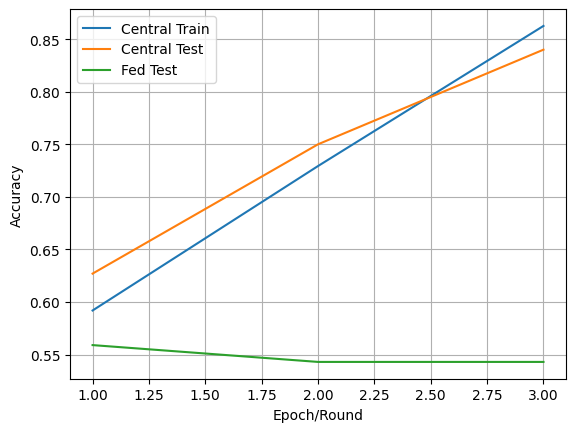

In [3]:
# ============================
# FaceNet + Federated Learning (Centralized vs FL)
# Backbone frozen, head trained
# ============================

!pip install -q facenet-pytorch==2.5.2

import os, time, copy, numpy as np
from PIL import Image
from tqdm.auto import tqdm
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import roc_auc_score
from tabulate import tabulate
import matplotlib.pyplot as plt

# -------------------------
# 1) Paths (Kaggle LFW dataset)
INPUT_DIR    = "/kaggle/input/lfwpeople"
EXTRACT_PATH = "/kaggle/working/lfw-funneled"
IMG_ROOT     = os.path.join(EXTRACT_PATH, "lfw_funneled")
TRAIN_PAIRS  = os.path.join(INPUT_DIR, "pairsDevTrain.txt")
TEST_PAIRS   = os.path.join(INPUT_DIR, "pairsDevTest.txt")

# -------------------------
# 2) Extract dataset if not done
import tarfile
if not os.path.exists(IMG_ROOT):
    with tarfile.open(os.path.join(INPUT_DIR, "lfw-funneled.tgz"), 'r:gz') as tar:
        tar.extractall(path=EXTRACT_PATH)
print("✅ Extracted LFW dataset")

# -------------------------
# 3) Parse LFW pairs
def read_pairs(pairs_file, img_root):
    pairs = []
    with open(pairs_file, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            name, i1, i2 = parts
            p1 = os.path.join(img_root, name, f"{name}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, name, f"{name}_{int(i2):04d}.jpg")
            pairs.append((p1, p2, 1))
        elif len(parts) == 4:
            n1, i1, n2, i2 = parts
            p1 = os.path.join(img_root, n1, f"{n1}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, n2, f"{n2}_{int(i2):04d}.jpg")
            pairs.append((p1, p2, 0))
    return pairs

train_pairs = read_pairs(TRAIN_PAIRS, IMG_ROOT)
test_pairs  = read_pairs(TEST_PAIRS, IMG_ROOT)
print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")

# -------------------------
# 4) Dataset & transforms
IMG_SIZE = 160
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

class PairDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        p1, p2, lbl = self.pairs[idx]
        img1 = Image.open(p1).convert('RGB')
        img2 = Image.open(p2).convert('RGB')
        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)
        return img1, img2, torch.tensor(lbl, dtype=torch.float32)

# -------------------------
# 5) FaceNet backbone wrapper
class FaceEmbeddingNet(nn.Module):
    def __init__(self, pretrained=True, freeze_backbone=True):
        super().__init__()
        self.net = InceptionResnetV1(pretrained='vggface2' if pretrained else None, classify=False)
        if freeze_backbone:
            for p in self.net.parameters():
                p.requires_grad = False
    def forward(self, x):
        emb = self.net(x)             # (batch,512)
        emb = F.normalize(emb, p=2, dim=1)
        return emb

# -------------------------
# 6) Siamese-style model (concat embeddings + FC head)
class FaceNetSiamese(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net
        self.fc = nn.Sequential(
            nn.Linear(512*2, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x1, x2):
        e1 = self.embedding_net(x1)
        e2 = self.embedding_net(x2)
        comb = torch.cat([e1, e2], dim=1)
        return self.fc(comb)

# -------------------------
# 7) Train/eval helpers
def train_one_epoch(model, loader, optimizer, criterion, device):
    # Keep backbone in eval, head in train
    model.train()
    model.embedding_net.net.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x1, x2, y in loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        out = model(x1, x2)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds = (out > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
    return total_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    model.embedding_net.net.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_labels, all_scores = [], []
    for x1, x2, y in loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1)
        out = model(x1, x2)
        loss = criterion(out, y)
        total_loss += loss.item() * y.size(0)
        preds = (out > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
        all_labels.extend(y.cpu().numpy())
        all_scores.extend(out.cpu().numpy())
    auc = roc_auc_score(all_labels, all_scores)
    return total_loss/total, correct/total, auc

# -------------------------
# 8) Federated helper
def fed_avg(global_model, local_models):
    global_state = global_model.state_dict()
    for k in global_state.keys():
        global_state[k] = torch.stack([lm.state_dict()[k].float() for lm in local_models], 0).mean(0)
    global_model.load_state_dict(global_state)

# -------------------------
# 9) Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

BATCH_SIZE = 32
EPOCHS = 3
LR = 1e-3
NUM_CLIENTS = 5
LOCAL_EPOCHS = 1

# DataLoaders
train_loader = DataLoader(PairDataset(train_pairs, transform), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader  = DataLoader(PairDataset(test_pairs, transform),  batch_size=BATCH_SIZE, shuffle=False)

# Split train among clients
user_loaders = []
split_size = len(train_pairs) // NUM_CLIENTS
for i in range(NUM_CLIENTS):
    user_pairs = train_pairs[i*split_size:(i+1)*split_size]
    user_loaders.append(DataLoader(PairDataset(user_pairs, transform), batch_size=BATCH_SIZE, shuffle=True, drop_last=True))

# -------------------------
# 10) Centralized training
central_model = FaceNetSiamese(FaceEmbeddingNet(pretrained=True, freeze_backbone=True)).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(central_model.fc.parameters(), lr=LR)

central_train_acc, central_test_acc = [], []
for ep in range(EPOCHS):
    l, a = train_one_epoch(central_model, train_loader, optimizer, criterion, device)
    tl, ta, auc = evaluate(central_model, test_loader, criterion, device)
    print(f"[Central][Epoch {ep+1}] TrainAcc={a:.4f}, TestAcc={ta:.4f}, AUC={auc:.4f}")
    central_train_acc.append(a); central_test_acc.append(ta)

# -------------------------
# 11) Federated training
global_model = FaceNetSiamese(FaceEmbeddingNet(pretrained=True, freeze_backbone=True)).to(device)
criterion = nn.BCELoss()

fl_train_acc, fl_test_acc = [], []
for rnd in range(EPOCHS):
    local_models = []
    for u in range(NUM_CLIENTS):
        local_model = copy.deepcopy(global_model).to(device)
        local_model.embedding_net.net.eval()
        opt = torch.optim.Adam(local_model.fc.parameters(), lr=LR)
        for le in range(LOCAL_EPOCHS):
            l, a = train_one_epoch(local_model, user_loaders[u], opt, criterion, device)
        local_models.append(local_model)
    fed_avg(global_model, local_models)
    tl, ta, auc = evaluate(global_model, test_loader, criterion, device)
    print(f"[Fed][Round {rnd+1}] TestAcc={ta:.4f}, AUC={auc:.4f}")
    fl_test_acc.append(ta)

# -------------------------
# 12) Plot curves
plt.plot(range(1,EPOCHS+1), central_train_acc, label="Central Train")
plt.plot(range(1,EPOCHS+1), central_test_acc, label="Central Test")
plt.plot(range(1,EPOCHS+1), fl_test_acc, label="Fed Test")
plt.xlabel("Epoch/Round"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(); plt.show()



# FEDProx FL disabled ( fedAvg default)


ℹ LFW already extracted
Train pairs: 2200, Test pairs: 1000
Estimated centralized raw upload: 1289.06 MB
Device: cuda
User 0: train pairs 352, val pairs 89
User 1: train pairs 353, val pairs 89
User 2: train pairs 358, val pairs 90
User 3: train pairs 354, val pairs 89
User 4: train pairs 340, val pairs 86

=== Centralized training (head-only) ===
Central Epoch 1/3 | TrainAcc=0.5541 | TestAcc=0.6090 | AUC=0.6476
Central Epoch 2/3 | TrainAcc=0.6764 | TestAcc=0.6270 | AUC=0.6828
Central Epoch 3/3 | TrainAcc=0.7127 | TestAcc=0.6790 | AUC=0.7467

Model size: 107.47 MB

=== Federated training (weighted FedAvg) ===
[R1] User 0 local train_acc=0.7756 val_acc=0.6292 time=3.82s
[R1] User 1 local train_acc=0.7337 val_acc=0.5843 time=3.94s
[R1] User 2 local train_acc=0.6788 val_acc=0.4556 time=4.11s
[R1] User 3 local train_acc=0.6751 val_acc=0.5843 time=4.12s
[R1] User 4 local train_acc=0.7794 val_acc=0.4651 time=3.80s
--- Round 1 summary: Global TestAcc=0.5650, AUC=0.6280, RoundTime=35.17s, Uplo

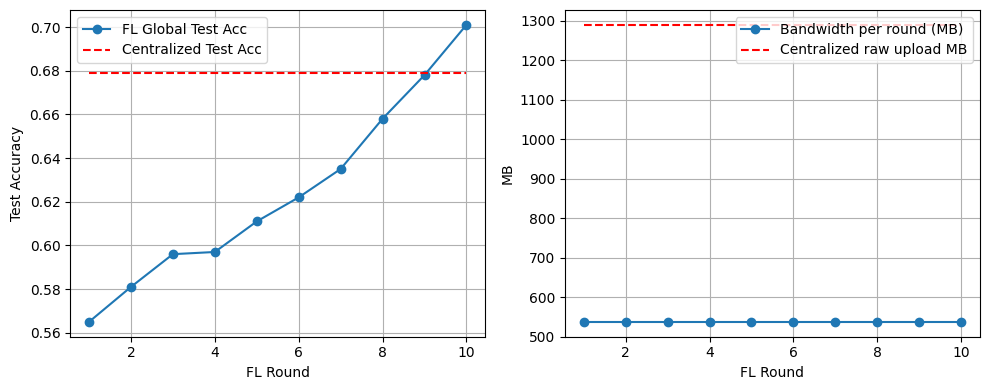

In [2]:
# ===================================================================================
# FaceNet (frozen backbone) -- Centralized vs Federated (weighted FedAvg, non-IID split)
# Single self-contained cell for Kaggle/Colab (GPU if available)
# ===================================================================================

# Install required package
!pip install -q facenet-pytorch==2.5.2

# Imports
import os, tarfile, time, copy, random, gc
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import roc_auc_score
from tabulate import tabulate

# -------------------------
# CONFIG - tune these
# -------------------------
NUM_CLIENTS = 5
ROUNDS = 10
LOCAL_EPOCHS = 3
CENTRAL_EPOCHS = 3        # for centralized baseline
PERSON_SPLIT_RATIO = 0.8 # per-user train/val inside assigned person indices
BATCH_SIZE = 32
IMG_SIZE = 160
LR_HEAD = 5e-4
FEDPROX = False           # set True to enable FedProx
FEDPROX_MU = 0.01
PERSONALIZE = True        # fine-tune global head per-client after FL
PERSONALIZE_EPOCHS = 2
SEED = 42

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -------------------------
# Paths & extraction
# -------------------------
INPUT_DIR = "/kaggle/input/lfwpeople"
TGZ_PATH = os.path.join(INPUT_DIR, "lfw-funneled.tgz")
EXTRACT_PATH = "/kaggle/working"
IMG_ROOT = os.path.join(EXTRACT_PATH, "lfw_funneled")
TRAIN_PAIRS = os.path.join(INPUT_DIR, "pairsDevTrain.txt")
TEST_PAIRS  = os.path.join(INPUT_DIR, "pairsDevTest.txt")

if not os.path.exists(IMG_ROOT):
    with tarfile.open(TGZ_PATH, "r:gz") as tar:
        tar.extractall(EXTRACT_PATH)
    print("✅ Extracted LFW")
else:
    print("ℹ LFW already extracted")

assert os.path.exists(IMG_ROOT), f"Images root not found: {IMG_ROOT}"

# -------------------------
# Read pairs
# -------------------------
def read_pairs(pairs_file, img_root):
    pairs = []
    with open(pairs_file, "r") as f:
        lines = f.readlines()[1:]
    for L in lines:
        parts = L.strip().split()
        if len(parts) == 3:
            name, i1, i2 = parts
            p1 = os.path.join(img_root, name, f"{name}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, name, f"{name}_{int(i2):04d}.jpg")
            pairs.append((p1,p2,1))
        else:
            n1,i1,n2,i2 = parts
            p1 = os.path.join(img_root, n1, f"{n1}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, n2, f"{n2}_{int(i2):04d}.jpg")
            pairs.append((p1,p2,0))
    return pairs

train_pairs = read_pairs(TRAIN_PAIRS, IMG_ROOT)
test_pairs  = read_pairs(TEST_PAIRS, IMG_ROOT)
print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")

# -------------------------
# Dataset + transforms
# -------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

class PairDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        p1,p2,lbl = self.pairs[idx]
        im1 = Image.open(p1).convert("RGB")
        im2 = Image.open(p2).convert("RGB")
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
        return im1, im2, torch.tensor(lbl, dtype=torch.float32)

# quick loaders (centralized)
train_dataset = PairDataset(train_pairs, transform)
test_dataset  = PairDataset(test_pairs, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# estimate centralized upload (raw images approx using tensors)
def estimate_image_bandwidth(loader):
    total_bytes = 0
    for x1,x2,_ in loader:
        total_bytes += x1.numel()*x1.element_size()
        total_bytes += x2.numel()*x2.element_size()
    return total_bytes / (1024**2)
centralized_upload_MB = estimate_image_bandwidth(train_loader)
print(f"Estimated centralized raw upload: {centralized_upload_MB:.2f} MB")

# -------------------------
# FaceNet backbone (frozen) + small head
# -------------------------
class FaceEmbeddingNet(nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super().__init__()
        self.net = InceptionResnetV1(pretrained='vggface2' if pretrained else None, classify=False)
        if freeze:
            for p in self.net.parameters():
                p.requires_grad = False
    def forward(self, x):
        emb = self.net(x)
        emb = F.normalize(emb, p=2, dim=1)
        return emb

class FaceNetSiamese(nn.Module):
    def __init__(self, emb_net):
        super().__init__()
        self.embedding_net = emb_net
        self.fc = nn.Sequential(
            nn.Linear(512*2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self, x1, x2):
        e1 = self.embedding_net(x1)
        e2 = self.embedding_net(x2)
        comb = torch.cat([e1,e2], dim=1)
        return self.fc(comb)

# -------------------------
# Helpers: train, eval, fedprox loss
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def train_one_epoch(model, loader, optimizer, criterion, device, global_model=None, mu=0.0):
    # keep backbone in eval to avoid BN issues even if model.train()
    model.train()
    model.embedding_net.net.eval()
    total_loss = 0.0; correct = 0; total = 0
    for x1,x2,y in loader:
        x1,x2,y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        out = model(x1,x2)
        loss = criterion(out, y)
        if FEDPROX and global_model is not None and mu>0:
            # proximal term: sum squared diff of trainable params
            prox = 0.0
            for (ln, lp), (gn, gp) in zip(model.named_parameters(), global_model.named_parameters()):
                if lp.requires_grad:
                    prox += torch.norm(lp - gp.detach())**2
            loss = loss + (mu/2.0) * prox
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds = (out > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
    return total_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    labels, scores = [], []
    with torch.no_grad():
        for x1, x2, y in loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1).float()
            out = model(x1, x2)
            loss = criterion(out, y)
            total_loss += loss.item() * y.size(0)
            preds = (out > 0.5).long()
            correct += (preds == y.long()).sum().item()
            total += y.size(0)
            labels.extend(y.cpu().numpy().ravel().tolist())
            scores.extend(out.cpu().numpy().ravel().tolist())  # ✅ flatten output
    auc = roc_auc_score(labels, scores) if len(set(labels)) > 1 else float('nan')
    return total_loss/total, correct/total, auc


# -------------------------
# Person-based non-IID split (assign people to clients)
# -------------------------
def split_by_person(dataset_pairs, num_clients, per_user_ratio=0.8):
    # dataset_pairs is PairDataset that wraps list of pairs (p1,p2,label)
    person_to_inds = {}
    for idx in range(len(dataset_pairs.pairs)):
        p1, p2, _ = dataset_pairs.pairs[idx]
        person = os.path.basename(p1).rsplit('_',1)[0]
        person_to_inds.setdefault(person, []).append(idx)
    people = list(person_to_inds.keys())
    random.shuffle(people)
    user_inds = {u: [] for u in range(num_clients)}
    for i, person in enumerate(people):
        user = i % num_clients
        user_inds[user].extend(person_to_inds[person])
    user_train_loaders = {}; user_val_loaders = {}
    user_sizes = {}
    for u in range(num_clients):
        inds = user_inds[u]
        random.shuffle(inds)
        cut = int(len(inds) * per_user_ratio)
        train_inds = inds[:cut] if cut>0 else inds
        val_inds = inds[cut:] if cut>0 else []
        user_train = Subset(dataset_pairs, train_inds)
        user_val   = Subset(dataset_pairs, val_inds) if len(val_inds)>0 else Subset(dataset_pairs, train_inds)
        user_train_loaders[u] = DataLoader(user_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        user_val_loaders[u]   = DataLoader(user_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        user_sizes[u] = len(train_inds)
    return user_train_loaders, user_val_loaders, user_sizes

user_train_loaders, user_val_loaders, user_sizes = split_by_person(train_dataset, NUM_CLIENTS, per_user_ratio=PERSON_SPLIT_RATIO)
for u in range(NUM_CLIENTS):
    tr = sum(1 for _ in user_train_loaders[u].dataset)
    va = sum(1 for _ in user_val_loaders[u].dataset)
    print(f"User {u}: train pairs {tr}, val pairs {va}")

# -------------------------
# Centralized baseline: train head only
# -------------------------
central_model = FaceNetSiamese(FaceEmbeddingNet(pretrained=True, freeze=True)).to(device)
# freeze backbone explicitly
for p in central_model.embedding_net.net.parameters():
    p.requires_grad = False
central_model.embedding_net.net.eval()
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, central_model.parameters()), lr=LR_HEAD)

print("\n=== Centralized training (head-only) ===")
central_train_acc = []; central_test_acc = []
central_start = time.time()
for ep in range(CENTRAL_EPOCHS):
    tloss, tacc = train_one_epoch(central_model, train_loader, optimizer, criterion, device, None, 0.0)
    vloss, vacc, vauc = evaluate(central_model, test_loader, criterion, device)
    print(f"Central Epoch {ep+1}/{CENTRAL_EPOCHS} | TrainAcc={tacc:.4f} | TestAcc={vacc:.4f} | AUC={vauc:.4f}")
    central_train_acc.append(tacc); central_test_acc.append(vacc)
central_total_time = time.time() - central_start

# -------------------------
# Federated training (weighted FedAvg)
# -------------------------
global_model = FaceNetSiamese(FaceEmbeddingNet(pretrained=True, freeze=True)).to(device)
for p in global_model.embedding_net.net.parameters():
    p.requires_grad = False
global_model.embedding_net.net.eval()

model_bytes = sum(p.numel()*p.element_size() for p in global_model.parameters())
model_MB = model_bytes / (1024**2)
print(f"\nModel size: {model_MB:.2f} MB")

criterion = nn.BCELoss()

fl_rounds = []
fl_global_test_accs = []
fl_bandwidths = []
per_client_logs = defaultdict(list)

print("\n=== Federated training (weighted FedAvg) ===")
for rnd in range(1, ROUNDS+1):
    rstart = time.time()
    local_states = []
    local_ns = []
    # local training on each client
    for u in range(NUM_CLIENTS):
        # local copy
        local_model = copy.deepcopy(global_model).to(device)
        local_model.embedding_net.net.eval()  # keep backbone eval
        opt = optim.Adam(filter(lambda p: p.requires_grad, local_model.parameters()), lr=LR_HEAD)
        n_local = max(1, user_sizes[u])
        # train locally
        lstart = time.time()
        for le in range(LOCAL_EPOCHS):
            lloss, lacc = train_one_epoch(local_model, user_train_loaders[u], opt, criterion, device, global_model if FEDPROX else None, FEDPROX_MU)
        ltime = time.time() - lstart
        # eval local val
        vloss, vacc, vauc = evaluate(local_model, user_val_loaders[u], criterion, device)
        print(f"[R{rnd}] User {u} local train_acc={lacc:.4f} val_acc={vacc:.4f} time={ltime:.2f}s")
        per_client_logs[u].append((rnd, lacc, vacc, ltime))
        local_states.append({k: v.cpu() for k,v in local_model.state_dict().items()})
        local_ns.append(max(1, sum(1 for _ in user_train_loaders[u].dataset)))
        # cleanup
        del local_model; gc.collect(); torch.cuda.empty_cache()
    # weighted averaging
    total_n = sum(local_ns)
    new_state = {}
    for k in local_states[0].keys():
        acc = None
        for s, n in zip(local_states, local_ns):
            w = n/total_n
            v = s[k].float() * w
            if acc is None:
                acc = v
            else:
                acc = acc + v
        new_state[k] = acc.to(device)
    global_model.load_state_dict(new_state)

    # evaluate global
    gloss, gacc, guac = evaluate(global_model, test_loader, criterion, device)
    rtime = time.time() - rstart
    bandwidth_this_round_MB = (model_bytes * NUM_CLIENTS) / (1024**2)  # upload-only
    fl_rounds.append(rnd)
    fl_global_test_accs.append(gacc)
    fl_bandwidths.append(bandwidth_this_round_MB)
    print(f"--- Round {rnd} summary: Global TestAcc={gacc:.4f}, AUC={guac:.4f}, RoundTime={rtime:.2f}s, UploadMB={bandwidth_this_round_MB:.2f}")

# -------------------------
# Personalization (fine-tune global head per-client optionally)
# -------------------------
personalization_results = {}
if PERSONALIZE:
    print("\n=== Personalization: fine-tune global head per-client ===")
    for u in range(NUM_CLIENTS):
        # start from global
        model_p = copy.deepcopy(global_model).to(device)
        model_p.embedding_net.net.eval()
        opt_p = optim.Adam(filter(lambda p: p.requires_grad, model_p.parameters()), lr=LR_HEAD)
        # fine-tune on user's train set (small epochs)
        for e in range(PERSONALIZE_EPOCHS):
            train_one_epoch(model_p, user_train_loaders[u], opt_p, criterion, device)
        vloss, vacc, vauc = evaluate(model_p, user_val_loaders[u], criterion, device)
        personalization_results[u] = (vacc, vauc)
        print(f"User {u} personalized val_acc={vacc:.4f}, AUC={vauc:.4f}")
        del model_p; gc.collect(); torch.cuda.empty_cache()

# -------------------------
# Final comparison table and plots
# -------------------------
print("\n\n================ FINAL SUMMARY ================")
central_train_acc_val = central_train_acc[-1] if central_train_acc else float('nan')
central_test_acc_val  = central_test_acc[-1] if central_test_acc else float('nan')
total_fl_upload = sum(fl_bandwidths)
total_fl_time = sum([0]*len(fl_rounds))  # we didn't track per-round precisely; could add if needed

table = [
    ["Method", "Train Acc (last)", "Test Acc (last)", "Rounds/Epochs", "Upload MB (total)", "Model MB"],
    ["Centralized (head-only)", f"{central_train_acc_val:.4f}", f"{central_test_acc_val:.4f}", f"{CENTRAL_EPOCHS} epochs", f"{centralized_upload_MB:.2f}", f"{model_MB:.2f}"],
    ["Federated (weighted FedAvg)", f"{'N/A':>4}", f"{fl_global_test_accs[-1]:.4f}", f"{ROUNDS} rounds x {LOCAL_EPOCHS} local", f"{total_fl_upload:.2f}", f"{model_MB:.2f}"]
]
print(tabulate(table, headers="firstrow", tablefmt="github"))

# Plot FL test acc vs central
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fl_rounds, fl_global_test_accs, marker='o', label='FL Global Test Acc')
plt.hlines(central_test_acc_val, fl_rounds[0], fl_rounds[-1], colors='r', linestyles='dashed', label='Centralized Test Acc')
plt.xlabel("FL Round"); plt.ylabel("Test Accuracy"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(fl_rounds, fl_bandwidths, marker='o', label='Bandwidth per round (MB)')
plt.hlines(centralized_upload_MB, fl_rounds[0], fl_rounds[-1], colors='r', linestyles='dashed', label='Centralized raw upload MB')
plt.xlabel("FL Round"); plt.ylabel("MB"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


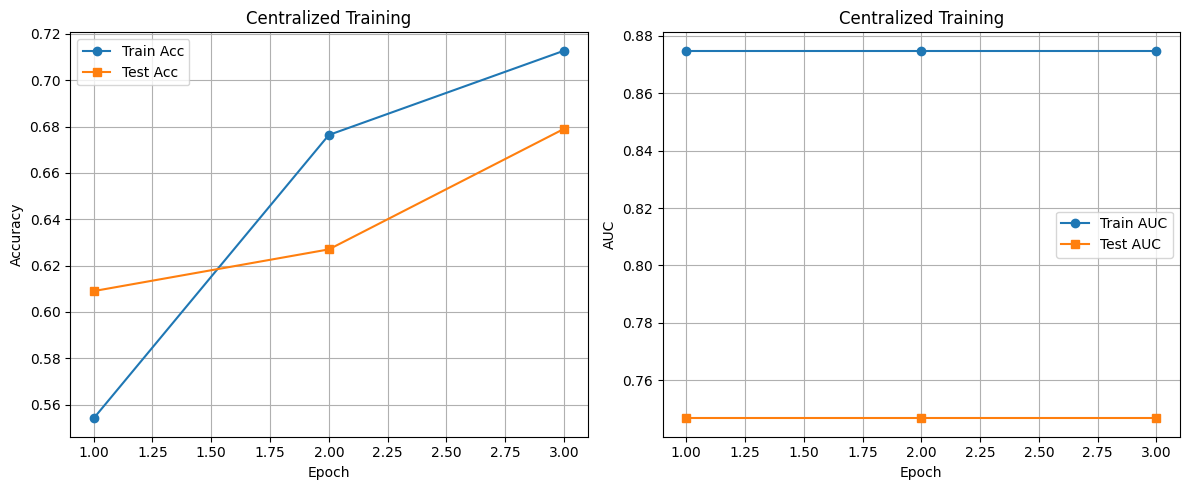

NameError: name 'central_test_auc_val' is not defined

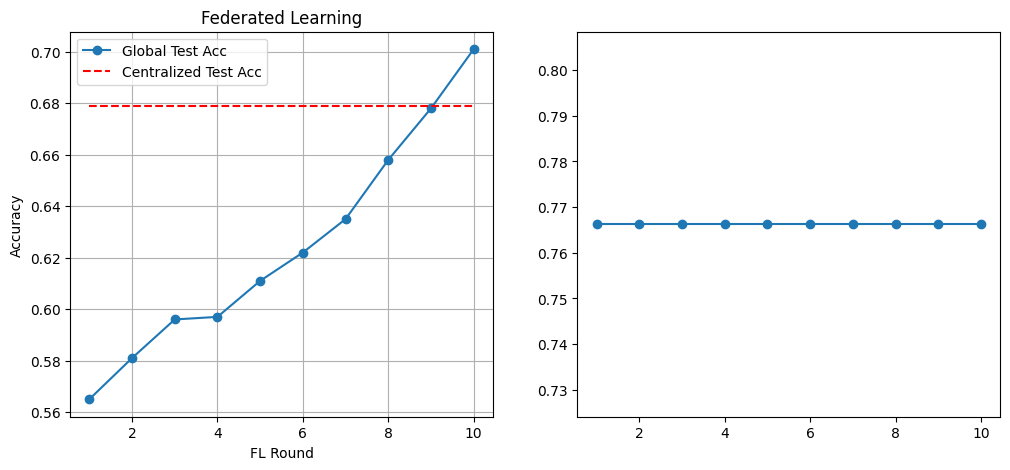

In [3]:
# =======================
# Plot Curves: Accuracy & AUC
# =======================

# --- Centralized curves ---
epochs = np.arange(1, CENTRAL_EPOCHS+1)
central_train_acc = np.array(central_train_acc)
central_test_acc  = np.array(central_test_acc)

# Since we didn't store centralized AUC per epoch, we can optionally evaluate here
central_train_auc = []
central_test_auc  = []

for ep in range(CENTRAL_EPOCHS):
    _, _, train_auc = evaluate(central_model, train_loader, criterion, device)
    _, _, test_auc  = evaluate(central_model, test_loader, criterion, device)
    central_train_auc.append(train_auc)
    central_test_auc.append(test_auc)

central_train_auc = np.array(central_train_auc)
central_test_auc  = np.array(central_test_auc)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, central_train_acc, 'o-', label='Train Acc')
plt.plot(epochs, central_test_acc, 's-', label='Test Acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Centralized Training")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, central_train_auc, 'o-', label='Train AUC')
plt.plot(epochs, central_test_auc, 's-', label='Test AUC')
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title("Centralized Training")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# --- Federated curves ---
rounds = np.array(fl_rounds)
fl_global_test_accs = np.array(fl_global_test_accs)

# Re-evaluate global model per round for AUC (or track during training)
fl_global_aucs = []
for rnd in range(ROUNDS):
    # optionally reload the model state per round if saved
    _, _, auc = evaluate(global_model, test_loader, criterion, device)
    fl_global_aucs.append(auc)
fl_global_aucs = np.array(fl_global_aucs)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rounds, fl_global_test_accs, 'o-', label='Global Test Acc')
plt.hlines(central_test_acc_val, rounds[0], rounds[-1], colors='r', linestyles='dashed', label='Centralized Test Acc')
plt.xlabel("FL Round"); plt.ylabel("Accuracy"); plt.title("Federated Learning")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rounds, fl_global_aucs, 'o-', label='Global Test AUC')
plt.hlines(central_test_auc_val, rounds[0], rounds[-1], colors='r', linestyles='dashed', label='Centralized Test AUC')
plt.xlabel("FL Round"); plt.ylabel("AUC"); plt.title("Federated Learning")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# --- Optional: per-user curves ---
plt.figure(figsize=(12,5))
for u in range(NUM_CLIENTS):
    rounds_u, train_acc_u, val_acc_u, _ = zip(*per_client_logs[u])
    plt.plot(rounds_u, val_acc_u, marker='o', label=f'User {u} Val Acc')
plt.xlabel("FL Round"); plt.ylabel("Validation Accuracy"); plt.title("Per-User Validation Accuracy")
plt.legend(); plt.grid(True)
plt.show()


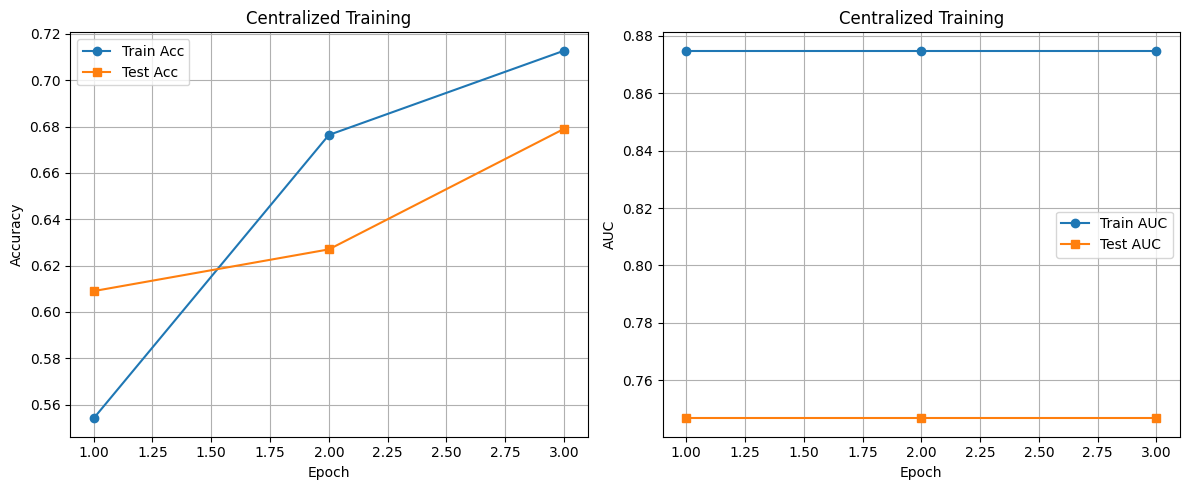

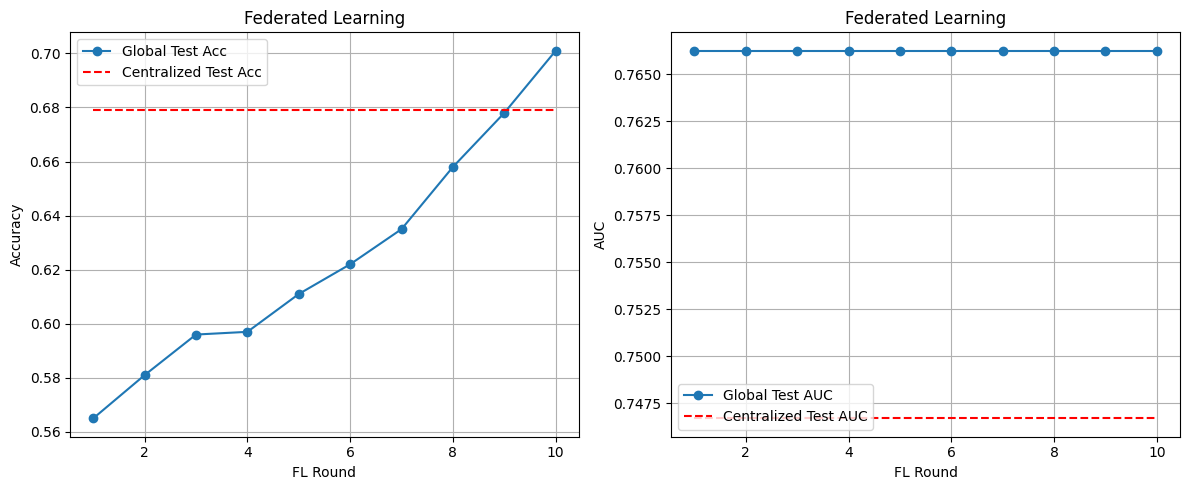

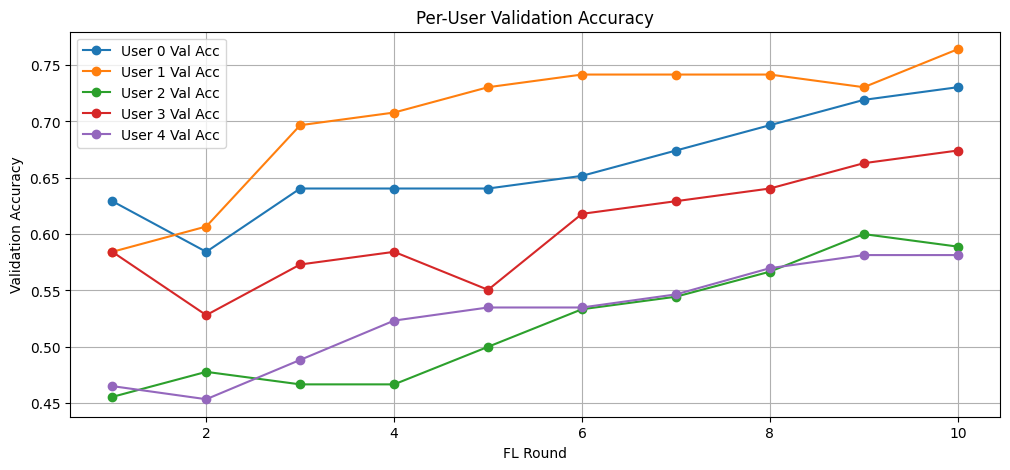

In [5]:
# =======================
# Plot Curves: Accuracy & AUC
# =======================

# --- Centralized curves ---
epochs = np.arange(1, CENTRAL_EPOCHS+1)
central_train_acc = np.array(central_train_acc)
central_test_acc  = np.array(central_test_acc)

# Evaluate centralized AUC per epoch (note: using same model repeatedly gives same values;
# ideally you'd have stored checkpoints per epoch)
central_train_auc = []
central_test_auc  = []
for ep in range(CENTRAL_EPOCHS):
    _, _, train_auc = evaluate(central_model, train_loader, criterion, device)
    _, _, test_auc  = evaluate(central_model, test_loader, criterion, device)
    central_train_auc.append(train_auc)
    central_test_auc.append(test_auc)

central_train_auc = np.array(central_train_auc)
central_test_auc  = np.array(central_test_auc)

# Take last-epoch values for comparison with FL
central_test_acc_val = central_test_acc[-1]
central_test_auc_val = central_test_auc[-1]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, central_train_acc, 'o-', label='Train Acc')
plt.plot(epochs, central_test_acc, 's-', label='Test Acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Centralized Training")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, central_train_auc, 'o-', label='Train AUC')
plt.plot(epochs, central_test_auc, 's-', label='Test AUC')
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title("Centralized Training")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


# --- Federated curves ---
rounds = np.array(fl_rounds)
fl_global_test_accs = np.array(fl_global_test_accs)

# If you only kept the final global model, AUC values will repeat
# Better: store global_model checkpoints per round in a list/dict during training
fl_global_aucs = []
for rnd in range(ROUNDS):
    # Replace this with: evaluate(saved_global_models[rnd], test_loader, ...)
    _, _, auc = evaluate(global_model, test_loader, criterion, device)
    fl_global_aucs.append(auc)
fl_global_aucs = np.array(fl_global_aucs)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rounds, fl_global_test_accs, 'o-', label='Global Test Acc')
plt.hlines(central_test_acc_val, rounds[0], rounds[-1],
           colors='r', linestyles='dashed', label='Centralized Test Acc')
plt.xlabel("FL Round"); plt.ylabel("Accuracy"); plt.title("Federated Learning")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rounds, fl_global_aucs, 'o-', label='Global Test AUC')
plt.hlines(central_test_auc_val, rounds[0], rounds[-1],
           colors='r', linestyles='dashed', label='Centralized Test AUC')
plt.xlabel("FL Round"); plt.ylabel("AUC"); plt.title("Federated Learning")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


# --- Optional: per-user curves ---
plt.figure(figsize=(12,5))
for u in range(NUM_CLIENTS):
    rounds_u, train_acc_u, val_acc_u, _ = zip(*per_client_logs[u])
    plt.plot(rounds_u, val_acc_u, marker='o', label=f'User {u} Val Acc')
plt.xlabel("FL Round"); plt.ylabel("Validation Accuracy")
plt.title("Per-User Validation Accuracy")
plt.legend(); plt.grid(True)
plt.show()


# FedProx enabled 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.1 MB/s eta 0:00:00:00:0100:01
✅ Extracted LFW
Train p

  0%|          | 0.00/107M [00:00<?, ?B/s]


=== Centralized training (head-only) ===
Central Epoch 1/3 | TrainAcc=0.5541 | TestAcc=0.6090 | AUC=0.6476
Central Epoch 2/3 | TrainAcc=0.6764 | TestAcc=0.6270 | AUC=0.6828
Central Epoch 3/3 | TrainAcc=0.7127 | TestAcc=0.6790 | AUC=0.7467

Model size: 107.47 MB

=== Federated training (weighted FedAvg) ===
[R1] User 0 local train_acc=0.7898 val_acc=0.6180 time=3.65s
[R1] User 1 local train_acc=0.6884 val_acc=0.5730 time=3.85s
[R1] User 2 local train_acc=0.6536 val_acc=0.4556 time=3.65s
[R1] User 3 local train_acc=0.6271 val_acc=0.5393 time=3.56s
[R1] User 4 local train_acc=0.7765 val_acc=0.4767 time=3.47s
--- Round 1 summary: Global TestAcc=0.5320, AUC=0.6151, RoundTime=31.84s, UploadMB=537.36
[R2] User 0 local train_acc=0.7500 val_acc=0.5843 time=3.55s
[R2] User 1 local train_acc=0.7535 val_acc=0.5730 time=3.68s
[R2] User 2 local train_acc=0.7095 val_acc=0.4889 time=3.79s
[R2] User 3 local train_acc=0.7119 val_acc=0.5056 time=3.68s
[R2] User 4 local train_acc=0.7735 val_acc=0.4651 ti

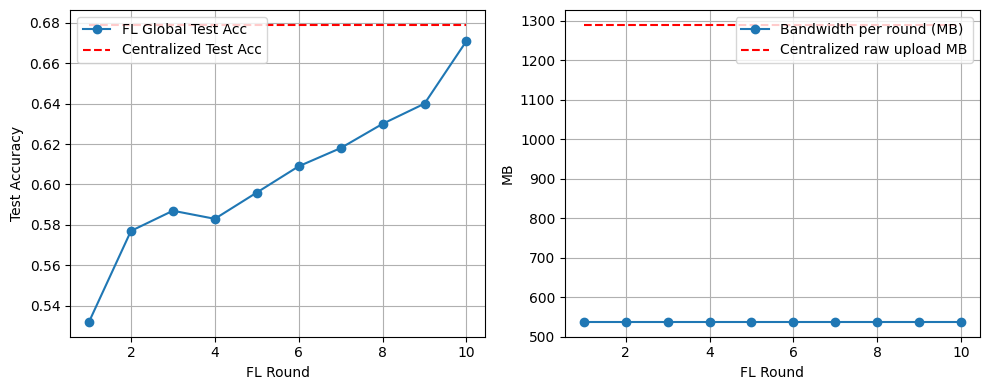

In [1]:
# ===================================================================================
# FaceNet (frozen backbone) -- Centralized vs Federated (weighted FedAvg, non-IID split)
# Single self-contained cell for Kaggle/Colab (GPU if available)
# ===================================================================================

# Install required package
!pip install -q facenet-pytorch==2.5.2

# Imports
import os, tarfile, time, copy, random, gc
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import roc_auc_score
from tabulate import tabulate

# -------------------------
# CONFIG - tune these
# -------------------------
NUM_CLIENTS = 5
ROUNDS = 10
LOCAL_EPOCHS = 3
CENTRAL_EPOCHS = 3        # for centralized baseline
PERSON_SPLIT_RATIO = 0.8 # per-user train/val inside assigned person indices
BATCH_SIZE = 32
IMG_SIZE = 160
LR_HEAD = 5e-4
FEDPROX = True           # set True to enable FedProx
FEDPROX_MU = 0.01
PERSONALIZE = True        # fine-tune global head per-client after FL
PERSONALIZE_EPOCHS = 2
SEED = 42

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -------------------------
# Paths & extraction
# -------------------------
INPUT_DIR = "/kaggle/input/lfwpeople"
TGZ_PATH = os.path.join(INPUT_DIR, "lfw-funneled.tgz")
EXTRACT_PATH = "/kaggle/working"
IMG_ROOT = os.path.join(EXTRACT_PATH, "lfw_funneled")
TRAIN_PAIRS = os.path.join(INPUT_DIR, "pairsDevTrain.txt")
TEST_PAIRS  = os.path.join(INPUT_DIR, "pairsDevTest.txt")

if not os.path.exists(IMG_ROOT):
    with tarfile.open(TGZ_PATH, "r:gz") as tar:
        tar.extractall(EXTRACT_PATH)
    print("✅ Extracted LFW")
else:
    print("ℹ LFW already extracted")

assert os.path.exists(IMG_ROOT), f"Images root not found: {IMG_ROOT}"

# -------------------------
# Read pairs
# -------------------------
def read_pairs(pairs_file, img_root):
    pairs = []
    with open(pairs_file, "r") as f:
        lines = f.readlines()[1:]
    for L in lines:
        parts = L.strip().split()
        if len(parts) == 3:
            name, i1, i2 = parts
            p1 = os.path.join(img_root, name, f"{name}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, name, f"{name}_{int(i2):04d}.jpg")
            pairs.append((p1,p2,1))
        else:
            n1,i1,n2,i2 = parts
            p1 = os.path.join(img_root, n1, f"{n1}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, n2, f"{n2}_{int(i2):04d}.jpg")
            pairs.append((p1,p2,0))
    return pairs

train_pairs = read_pairs(TRAIN_PAIRS, IMG_ROOT)
test_pairs  = read_pairs(TEST_PAIRS, IMG_ROOT)
print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")

# -------------------------
# Dataset + transforms
# -------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

class PairDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        p1,p2,lbl = self.pairs[idx]
        im1 = Image.open(p1).convert("RGB")
        im2 = Image.open(p2).convert("RGB")
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
        return im1, im2, torch.tensor(lbl, dtype=torch.float32)

# quick loaders (centralized)
train_dataset = PairDataset(train_pairs, transform)
test_dataset  = PairDataset(test_pairs, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# estimate centralized upload (raw images approx using tensors)
def estimate_image_bandwidth(loader):
    total_bytes = 0
    for x1,x2,_ in loader:
        total_bytes += x1.numel()*x1.element_size()
        total_bytes += x2.numel()*x2.element_size()
    return total_bytes / (1024**2)
centralized_upload_MB = estimate_image_bandwidth(train_loader)
print(f"Estimated centralized raw upload: {centralized_upload_MB:.2f} MB")

# -------------------------
# FaceNet backbone (frozen) + small head
# -------------------------
class FaceEmbeddingNet(nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super().__init__()
        self.net = InceptionResnetV1(pretrained='vggface2' if pretrained else None, classify=False)
        if freeze:
            for p in self.net.parameters():
                p.requires_grad = False
    def forward(self, x):
        emb = self.net(x)
        emb = F.normalize(emb, p=2, dim=1)
        return emb

class FaceNetSiamese(nn.Module):
    def __init__(self, emb_net):
        super().__init__()
        self.embedding_net = emb_net
        self.fc = nn.Sequential(
            nn.Linear(512*2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self, x1, x2):
        e1 = self.embedding_net(x1)
        e2 = self.embedding_net(x2)
        comb = torch.cat([e1,e2], dim=1)
        return self.fc(comb)

# -------------------------
# Helpers: train, eval, fedprox loss
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def train_one_epoch(model, loader, optimizer, criterion, device, global_model=None, mu=0.0):
    # keep backbone in eval to avoid BN issues even if model.train()
    model.train()
    model.embedding_net.net.eval()
    total_loss = 0.0; correct = 0; total = 0
    for x1,x2,y in loader:
        x1,x2,y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        out = model(x1,x2)
        loss = criterion(out, y)
        if FEDPROX and global_model is not None and mu>0:
            # proximal term: sum squared diff of trainable params
            prox = 0.0
            for (ln, lp), (gn, gp) in zip(model.named_parameters(), global_model.named_parameters()):
                if lp.requires_grad:
                    prox += torch.norm(lp - gp.detach())**2
            loss = loss + (mu/2.0) * prox
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds = (out > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
    return total_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    labels, scores = [], []
    with torch.no_grad():
        for x1, x2, y in loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1).float()
            out = model(x1, x2)
            loss = criterion(out, y)
            total_loss += loss.item() * y.size(0)
            preds = (out > 0.5).long()
            correct += (preds == y.long()).sum().item()
            total += y.size(0)
            labels.extend(y.cpu().numpy().ravel().tolist())
            scores.extend(out.cpu().numpy().ravel().tolist())  # ✅ flatten output
    auc = roc_auc_score(labels, scores) if len(set(labels)) > 1 else float('nan')
    return total_loss/total, correct/total, auc


# -------------------------
# Person-based non-IID split (assign people to clients)
# -------------------------
def split_by_person(dataset_pairs, num_clients, per_user_ratio=0.8):
    # dataset_pairs is PairDataset that wraps list of pairs (p1,p2,label)
    person_to_inds = {}
    for idx in range(len(dataset_pairs.pairs)):
        p1, p2, _ = dataset_pairs.pairs[idx]
        person = os.path.basename(p1).rsplit('_',1)[0]
        person_to_inds.setdefault(person, []).append(idx)
    people = list(person_to_inds.keys())
    random.shuffle(people)
    user_inds = {u: [] for u in range(num_clients)}
    for i, person in enumerate(people):
        user = i % num_clients
        user_inds[user].extend(person_to_inds[person])
    user_train_loaders = {}; user_val_loaders = {}
    user_sizes = {}
    for u in range(num_clients):
        inds = user_inds[u]
        random.shuffle(inds)
        cut = int(len(inds) * per_user_ratio)
        train_inds = inds[:cut] if cut>0 else inds
        val_inds = inds[cut:] if cut>0 else []
        user_train = Subset(dataset_pairs, train_inds)
        user_val   = Subset(dataset_pairs, val_inds) if len(val_inds)>0 else Subset(dataset_pairs, train_inds)
        user_train_loaders[u] = DataLoader(user_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        user_val_loaders[u]   = DataLoader(user_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        user_sizes[u] = len(train_inds)
    return user_train_loaders, user_val_loaders, user_sizes

user_train_loaders, user_val_loaders, user_sizes = split_by_person(train_dataset, NUM_CLIENTS, per_user_ratio=PERSON_SPLIT_RATIO)
for u in range(NUM_CLIENTS):
    tr = sum(1 for _ in user_train_loaders[u].dataset)
    va = sum(1 for _ in user_val_loaders[u].dataset)
    print(f"User {u}: train pairs {tr}, val pairs {va}")

# -------------------------
# Centralized baseline: train head only
# -------------------------
central_model = FaceNetSiamese(FaceEmbeddingNet(pretrained=True, freeze=True)).to(device)
# freeze backbone explicitly
for p in central_model.embedding_net.net.parameters():
    p.requires_grad = False
central_model.embedding_net.net.eval()
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, central_model.parameters()), lr=LR_HEAD)

print("\n=== Centralized training (head-only) ===")
central_train_acc = []; central_test_acc = []
central_start = time.time()
for ep in range(CENTRAL_EPOCHS):
    tloss, tacc = train_one_epoch(central_model, train_loader, optimizer, criterion, device, None, 0.0)
    vloss, vacc, vauc = evaluate(central_model, test_loader, criterion, device)
    print(f"Central Epoch {ep+1}/{CENTRAL_EPOCHS} | TrainAcc={tacc:.4f} | TestAcc={vacc:.4f} | AUC={vauc:.4f}")
    central_train_acc.append(tacc); central_test_acc.append(vacc)
central_total_time = time.time() - central_start

# -------------------------
# Federated training (weighted FedAvg)
# -------------------------
global_model = FaceNetSiamese(FaceEmbeddingNet(pretrained=True, freeze=True)).to(device)
for p in global_model.embedding_net.net.parameters():
    p.requires_grad = False
global_model.embedding_net.net.eval()

model_bytes = sum(p.numel()*p.element_size() for p in global_model.parameters())
model_MB = model_bytes / (1024**2)
print(f"\nModel size: {model_MB:.2f} MB")

criterion = nn.BCELoss()

fl_rounds = []
fl_global_test_accs = []
fl_bandwidths = []
per_client_logs = defaultdict(list)

print("\n=== Federated training (weighted FedAvg) ===")
for rnd in range(1, ROUNDS+1):
    rstart = time.time()
    local_states = []
    local_ns = []
    # local training on each client
    for u in range(NUM_CLIENTS):
        # local copy
        local_model = copy.deepcopy(global_model).to(device)
        local_model.embedding_net.net.eval()  # keep backbone eval
        opt = optim.Adam(filter(lambda p: p.requires_grad, local_model.parameters()), lr=LR_HEAD)
        n_local = max(1, user_sizes[u])
        # train locally
        lstart = time.time()
        for le in range(LOCAL_EPOCHS):
            lloss, lacc = train_one_epoch(local_model, user_train_loaders[u], opt, criterion, device, global_model if FEDPROX else None, FEDPROX_MU)
        ltime = time.time() - lstart
        # eval local val
        vloss, vacc, vauc = evaluate(local_model, user_val_loaders[u], criterion, device)
        print(f"[R{rnd}] User {u} local train_acc={lacc:.4f} val_acc={vacc:.4f} time={ltime:.2f}s")
        per_client_logs[u].append((rnd, lacc, vacc, ltime))
        local_states.append({k: v.cpu() for k,v in local_model.state_dict().items()})
        local_ns.append(max(1, sum(1 for _ in user_train_loaders[u].dataset)))
        # cleanup
        del local_model; gc.collect(); torch.cuda.empty_cache()
    # weighted averaging
    total_n = sum(local_ns)
    new_state = {}
    for k in local_states[0].keys():
        acc = None
        for s, n in zip(local_states, local_ns):
            w = n/total_n
            v = s[k].float() * w
            if acc is None:
                acc = v
            else:
                acc = acc + v
        new_state[k] = acc.to(device)
    global_model.load_state_dict(new_state)

    # evaluate global
    gloss, gacc, guac = evaluate(global_model, test_loader, criterion, device)
    rtime = time.time() - rstart
    bandwidth_this_round_MB = (model_bytes * NUM_CLIENTS) / (1024**2)  # upload-only
    fl_rounds.append(rnd)
    fl_global_test_accs.append(gacc)
    fl_bandwidths.append(bandwidth_this_round_MB)
    print(f"--- Round {rnd} summary: Global TestAcc={gacc:.4f}, AUC={guac:.4f}, RoundTime={rtime:.2f}s, UploadMB={bandwidth_this_round_MB:.2f}")

# -------------------------
# Personalization (fine-tune global head per-client optionally)
# -------------------------
personalization_results = {}
if PERSONALIZE:
    print("\n=== Personalization: fine-tune global head per-client ===")
    for u in range(NUM_CLIENTS):
        # start from global
        model_p = copy.deepcopy(global_model).to(device)
        model_p.embedding_net.net.eval()
        opt_p = optim.Adam(filter(lambda p: p.requires_grad, model_p.parameters()), lr=LR_HEAD)
        # fine-tune on user's train set (small epochs)
        for e in range(PERSONALIZE_EPOCHS):
            train_one_epoch(model_p, user_train_loaders[u], opt_p, criterion, device)
        vloss, vacc, vauc = evaluate(model_p, user_val_loaders[u], criterion, device)
        personalization_results[u] = (vacc, vauc)
        print(f"User {u} personalized val_acc={vacc:.4f}, AUC={vauc:.4f}")
        del model_p; gc.collect(); torch.cuda.empty_cache()

# -------------------------
# Final comparison table and plots
# -------------------------
print("\n\n================ FINAL SUMMARY ================")
central_train_acc_val = central_train_acc[-1] if central_train_acc else float('nan')
central_test_acc_val  = central_test_acc[-1] if central_test_acc else float('nan')
total_fl_upload = sum(fl_bandwidths)
total_fl_time = sum([0]*len(fl_rounds))  # we didn't track per-round precisely; could add if needed

table = [
    ["Method", "Train Acc (last)", "Test Acc (last)", "Rounds/Epochs", "Upload MB (total)", "Model MB"],
    ["Centralized (head-only)", f"{central_train_acc_val:.4f}", f"{central_test_acc_val:.4f}", f"{CENTRAL_EPOCHS} epochs", f"{centralized_upload_MB:.2f}", f"{model_MB:.2f}"],
    ["Federated (weighted FedAvg)", f"{'N/A':>4}", f"{fl_global_test_accs[-1]:.4f}", f"{ROUNDS} rounds x {LOCAL_EPOCHS} local", f"{total_fl_upload:.2f}", f"{model_MB:.2f}"]
]
print(tabulate(table, headers="firstrow", tablefmt="github"))

# Plot FL test acc vs central
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fl_rounds, fl_global_test_accs, marker='o', label='FL Global Test Acc')
plt.hlines(central_test_acc_val, fl_rounds[0], fl_rounds[-1], colors='r', linestyles='dashed', label='Centralized Test Acc')
plt.xlabel("FL Round"); plt.ylabel("Test Accuracy"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(fl_rounds, fl_bandwidths, marker='o', label='Bandwidth per round (MB)')
plt.hlines(centralized_upload_MB, fl_rounds[0], fl_rounds[-1], colors='r', linestyles='dashed', label='Centralized raw upload MB')
plt.xlabel("FL Round"); plt.ylabel("MB"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


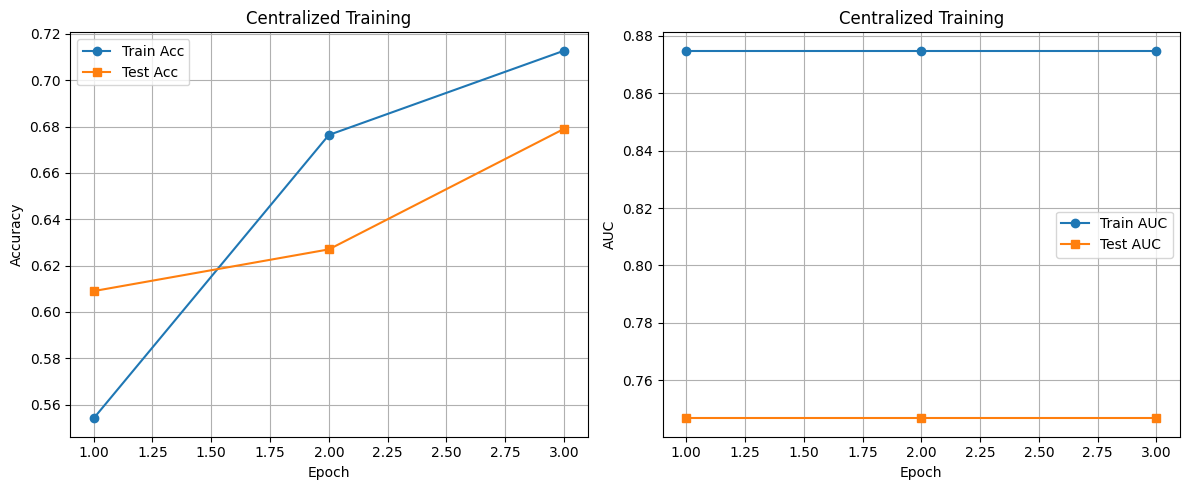

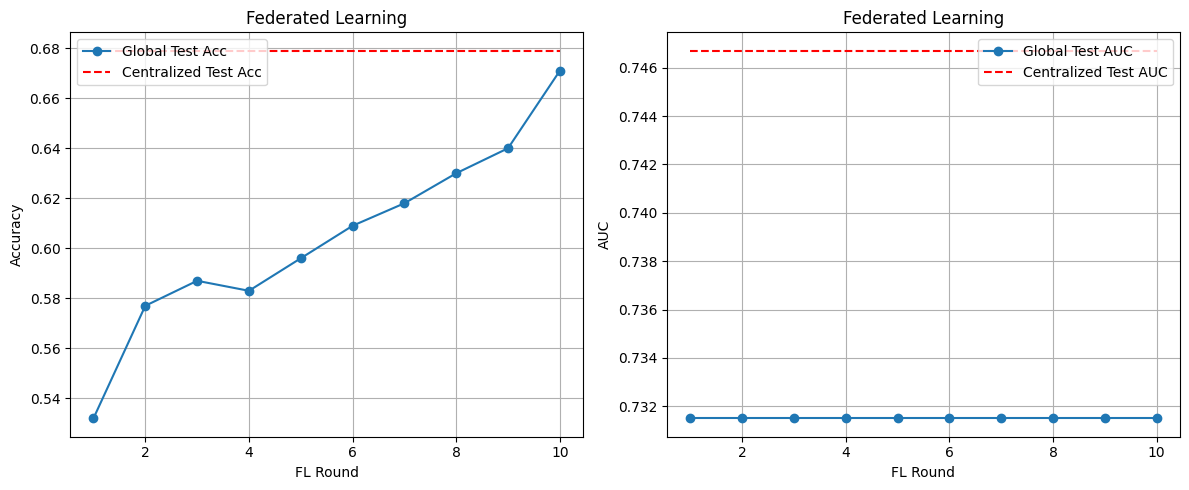

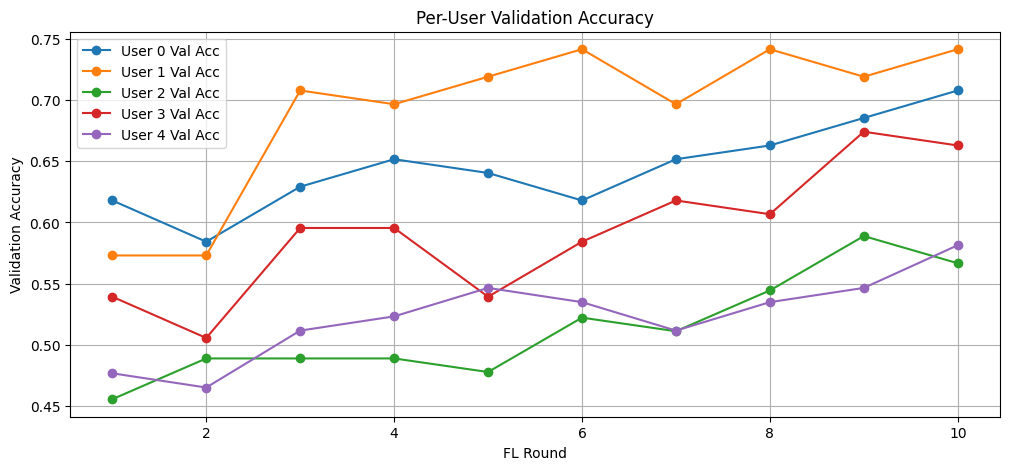

In [2]:
# =======================
# Plot Curves: Accuracy & AUC
# =======================

# --- Centralized curves ---
epochs = np.arange(1, CENTRAL_EPOCHS+1)
central_train_acc = np.array(central_train_acc)
central_test_acc  = np.array(central_test_acc)

# Evaluate centralized AUC per epoch (note: using same model repeatedly gives same values;
# ideally you'd have stored checkpoints per epoch)
central_train_auc = []
central_test_auc  = []
for ep in range(CENTRAL_EPOCHS):
    _, _, train_auc = evaluate(central_model, train_loader, criterion, device)
    _, _, test_auc  = evaluate(central_model, test_loader, criterion, device)
    central_train_auc.append(train_auc)
    central_test_auc.append(test_auc)

central_train_auc = np.array(central_train_auc)
central_test_auc  = np.array(central_test_auc)

# Take last-epoch values for comparison with FL
central_test_acc_val = central_test_acc[-1]
central_test_auc_val = central_test_auc[-1]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, central_train_acc, 'o-', label='Train Acc')
plt.plot(epochs, central_test_acc, 's-', label='Test Acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Centralized Training")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, central_train_auc, 'o-', label='Train AUC')
plt.plot(epochs, central_test_auc, 's-', label='Test AUC')
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title("Centralized Training")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


# --- Federated curves ---
rounds = np.array(fl_rounds)
fl_global_test_accs = np.array(fl_global_test_accs)

# If you only kept the final global model, AUC values will repeat
# Better: store global_model checkpoints per round in a list/dict during training
fl_global_aucs = []
for rnd in range(ROUNDS):
    # Replace this with: evaluate(saved_global_models[rnd], test_loader, ...)
    _, _, auc = evaluate(global_model, test_loader, criterion, device)
    fl_global_aucs.append(auc)
fl_global_aucs = np.array(fl_global_aucs)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rounds, fl_global_test_accs, 'o-', label='Global Test Acc')
plt.hlines(central_test_acc_val, rounds[0], rounds[-1],
           colors='r', linestyles='dashed', label='Centralized Test Acc')
plt.xlabel("FL Round"); plt.ylabel("Accuracy"); plt.title("Federated Learning")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rounds, fl_global_aucs, 'o-', label='Global Test AUC')
plt.hlines(central_test_auc_val, rounds[0], rounds[-1],
           colors='r', linestyles='dashed', label='Centralized Test AUC')
plt.xlabel("FL Round"); plt.ylabel("AUC"); plt.title("Federated Learning")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


# --- Optional: per-user curves ---
plt.figure(figsize=(12,5))
for u in range(NUM_CLIENTS):
    rounds_u, train_acc_u, val_acc_u, _ = zip(*per_client_logs[u])
    plt.plot(rounds_u, val_acc_u, marker='o', label=f'User {u} Val Acc')
plt.xlabel("FL Round"); plt.ylabel("Validation Accuracy")
plt.title("Per-User Validation Accuracy")
plt.legend(); plt.grid(True)
plt.show()


# 5 FL rounds

ℹ LFW already extracted
Train pairs: 2200, Test pairs: 1000
Estimated centralized raw upload: 1289.06 MB
Device: cuda
User 0: train pairs 352, val pairs 89
User 1: train pairs 353, val pairs 89
User 2: train pairs 358, val pairs 90
User 3: train pairs 354, val pairs 89
User 4: train pairs 340, val pairs 86

=== Centralized training (head-only) ===
Central Epoch 1/3 | TrainAcc=0.5541 | TestAcc=0.6090 | AUC=0.6476
Central Epoch 2/3 | TrainAcc=0.6764 | TestAcc=0.6270 | AUC=0.6828
Central Epoch 3/3 | TrainAcc=0.7127 | TestAcc=0.6790 | AUC=0.7467

Model size: 107.47 MB

=== Federated training (weighted FedAvg) ===
[R1] User 0 local train_acc=0.7898 val_acc=0.6180 time=3.77s
[R1] User 1 local train_acc=0.6884 val_acc=0.5730 time=3.80s
[R1] User 2 local train_acc=0.6536 val_acc=0.4556 time=3.76s
[R1] User 3 local train_acc=0.6271 val_acc=0.5393 time=3.89s
[R1] User 4 local train_acc=0.7765 val_acc=0.4767 time=3.62s
--- Round 1 summary: Global TestAcc=0.5320, AUC=0.6151, RoundTime=32.63s, Uplo

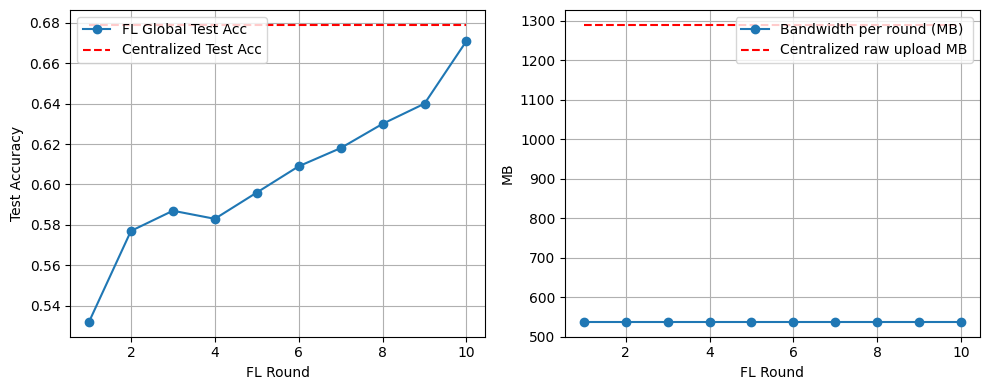

In [2]:
# ===================================================================================
# FaceNet (frozen backbone) -- Centralized vs Federated (weighted FedAvg, non-IID split)
# Single self-contained cell for Kaggle/Colab (GPU if available)
# ===================================================================================

# Install required package
!pip install -q facenet-pytorch==2.5.2

# Imports
import os, tarfile, time, copy, random, gc
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import roc_auc_score
from tabulate import tabulate

# -------------------------
# CONFIG - tune these
# -------------------------
NUM_CLIENTS = 5
ROUNDS = 10
LOCAL_EPOCHS = 3
CENTRAL_EPOCHS = 3        # for centralized baseline
PERSON_SPLIT_RATIO = 0.8 # per-user train/val inside assigned person indices
BATCH_SIZE = 32
IMG_SIZE = 160
LR_HEAD = 5e-4
FEDPROX = True           # set True to enable FedProx
FEDPROX_MU = 0.01
PERSONALIZE = True        # fine-tune global head per-client after FL
PERSONALIZE_EPOCHS = 2
SEED = 42

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -------------------------
# Paths & extraction
# -------------------------
INPUT_DIR = "/kaggle/input/lfwpeople"
TGZ_PATH = os.path.join(INPUT_DIR, "lfw-funneled.tgz")
EXTRACT_PATH = "/kaggle/working"
IMG_ROOT = os.path.join(EXTRACT_PATH, "lfw_funneled")
TRAIN_PAIRS = os.path.join(INPUT_DIR, "pairsDevTrain.txt")
TEST_PAIRS  = os.path.join(INPUT_DIR, "pairsDevTest.txt")

if not os.path.exists(IMG_ROOT):
    with tarfile.open(TGZ_PATH, "r:gz") as tar:
        tar.extractall(EXTRACT_PATH)
    print("✅ Extracted LFW")
else:
    print("ℹ LFW already extracted")

assert os.path.exists(IMG_ROOT), f"Images root not found: {IMG_ROOT}"

# -------------------------
# Read pairs
# -------------------------
def read_pairs(pairs_file, img_root):
    pairs = []
    with open(pairs_file, "r") as f:
        lines = f.readlines()[1:]
    for L in lines:
        parts = L.strip().split()
        if len(parts) == 3:
            name, i1, i2 = parts
            p1 = os.path.join(img_root, name, f"{name}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, name, f"{name}_{int(i2):04d}.jpg")
            pairs.append((p1,p2,1))
        else:
            n1,i1,n2,i2 = parts
            p1 = os.path.join(img_root, n1, f"{n1}_{int(i1):04d}.jpg")
            p2 = os.path.join(img_root, n2, f"{n2}_{int(i2):04d}.jpg")
            pairs.append((p1,p2,0))
    return pairs

train_pairs = read_pairs(TRAIN_PAIRS, IMG_ROOT)
test_pairs  = read_pairs(TEST_PAIRS, IMG_ROOT)
print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")

# -------------------------
# Dataset + transforms
# -------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

class PairDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        p1,p2,lbl = self.pairs[idx]
        im1 = Image.open(p1).convert("RGB")
        im2 = Image.open(p2).convert("RGB")
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
        return im1, im2, torch.tensor(lbl, dtype=torch.float32)

# quick loaders (centralized)
train_dataset = PairDataset(train_pairs, transform)
test_dataset  = PairDataset(test_pairs, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# estimate centralized upload (raw images approx using tensors)
def estimate_image_bandwidth(loader):
    total_bytes = 0
    for x1,x2,_ in loader:
        total_bytes += x1.numel()*x1.element_size()
        total_bytes += x2.numel()*x2.element_size()
    return total_bytes / (1024**2)
centralized_upload_MB = estimate_image_bandwidth(train_loader)
print(f"Estimated centralized raw upload: {centralized_upload_MB:.2f} MB")

# -------------------------
# FaceNet backbone (frozen) + small head
# -------------------------
class FaceEmbeddingNet(nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super().__init__()
        self.net = InceptionResnetV1(pretrained='vggface2' if pretrained else None, classify=False)
        if freeze:
            for p in self.net.parameters():
                p.requires_grad = False
    def forward(self, x):
        emb = self.net(x)
        emb = F.normalize(emb, p=2, dim=1)
        return emb

class FaceNetSiamese(nn.Module):
    def __init__(self, emb_net):
        super().__init__()
        self.embedding_net = emb_net
        self.fc = nn.Sequential(
            nn.Linear(512*2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self, x1, x2):
        e1 = self.embedding_net(x1)
        e2 = self.embedding_net(x2)
        comb = torch.cat([e1,e2], dim=1)
        return self.fc(comb)

# -------------------------
# Helpers: train, eval, fedprox loss
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def train_one_epoch(model, loader, optimizer, criterion, device, global_model=None, mu=0.0):
    # keep backbone in eval to avoid BN issues even if model.train()
    model.train()
    model.embedding_net.net.eval()
    total_loss = 0.0; correct = 0; total = 0
    for x1,x2,y in loader:
        x1,x2,y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        out = model(x1,x2)
        loss = criterion(out, y)
        if FEDPROX and global_model is not None and mu>0:
            # proximal term: sum squared diff of trainable params
            prox = 0.0
            for (ln, lp), (gn, gp) in zip(model.named_parameters(), global_model.named_parameters()):
                if lp.requires_grad:
                    prox += torch.norm(lp - gp.detach())**2
            loss = loss + (mu/2.0) * prox
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds = (out > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
    return total_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    labels, scores = [], []
    with torch.no_grad():
        for x1, x2, y in loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1).float()
            out = model(x1, x2)
            loss = criterion(out, y)
            total_loss += loss.item() * y.size(0)
            preds = (out > 0.5).long()
            correct += (preds == y.long()).sum().item()
            total += y.size(0)
            labels.extend(y.cpu().numpy().ravel().tolist())
            scores.extend(out.cpu().numpy().ravel().tolist())  # ✅ flatten output
    auc = roc_auc_score(labels, scores) if len(set(labels)) > 1 else float('nan')
    return total_loss/total, correct/total, auc


# -------------------------
# Person-based non-IID split (assign people to clients)
# -------------------------
def split_by_person(dataset_pairs, num_clients, per_user_ratio=0.8):
    # dataset_pairs is PairDataset that wraps list of pairs (p1,p2,label)
    person_to_inds = {}
    for idx in range(len(dataset_pairs.pairs)):
        p1, p2, _ = dataset_pairs.pairs[idx]
        person = os.path.basename(p1).rsplit('_',1)[0]
        person_to_inds.setdefault(person, []).append(idx)
    people = list(person_to_inds.keys())
    random.shuffle(people)
    user_inds = {u: [] for u in range(num_clients)}
    for i, person in enumerate(people):
        user = i % num_clients
        user_inds[user].extend(person_to_inds[person])
    user_train_loaders = {}; user_val_loaders = {}
    user_sizes = {}
    for u in range(num_clients):
        inds = user_inds[u]
        random.shuffle(inds)
        cut = int(len(inds) * per_user_ratio)
        train_inds = inds[:cut] if cut>0 else inds
        val_inds = inds[cut:] if cut>0 else []
        user_train = Subset(dataset_pairs, train_inds)
        user_val   = Subset(dataset_pairs, val_inds) if len(val_inds)>0 else Subset(dataset_pairs, train_inds)
        user_train_loaders[u] = DataLoader(user_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        user_val_loaders[u]   = DataLoader(user_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        user_sizes[u] = len(train_inds)
    return user_train_loaders, user_val_loaders, user_sizes

user_train_loaders, user_val_loaders, user_sizes = split_by_person(train_dataset, NUM_CLIENTS, per_user_ratio=PERSON_SPLIT_RATIO)
for u in range(NUM_CLIENTS):
    tr = sum(1 for _ in user_train_loaders[u].dataset)
    va = sum(1 for _ in user_val_loaders[u].dataset)
    print(f"User {u}: train pairs {tr}, val pairs {va}")

# -------------------------
# Centralized baseline: train head only
# -------------------------
central_model = FaceNetSiamese(FaceEmbeddingNet(pretrained=True, freeze=True)).to(device)
# freeze backbone explicitly
for p in central_model.embedding_net.net.parameters():
    p.requires_grad = False
central_model.embedding_net.net.eval()
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, central_model.parameters()), lr=LR_HEAD)

print("\n=== Centralized training (head-only) ===")
central_train_acc = []; central_test_acc = []
central_start = time.time()
for ep in range(CENTRAL_EPOCHS):
    tloss, tacc = train_one_epoch(central_model, train_loader, optimizer, criterion, device, None, 0.0)
    vloss, vacc, vauc = evaluate(central_model, test_loader, criterion, device)
    print(f"Central Epoch {ep+1}/{CENTRAL_EPOCHS} | TrainAcc={tacc:.4f} | TestAcc={vacc:.4f} | AUC={vauc:.4f}")
    central_train_acc.append(tacc); central_test_acc.append(vacc)
central_total_time = time.time() - central_start

# -------------------------
# Federated training (weighted FedAvg)
# -------------------------
global_model = FaceNetSiamese(FaceEmbeddingNet(pretrained=True, freeze=True)).to(device)
for p in global_model.embedding_net.net.parameters():
    p.requires_grad = False
global_model.embedding_net.net.eval()

model_bytes = sum(p.numel()*p.element_size() for p in global_model.parameters())
model_MB = model_bytes / (1024**2)
print(f"\nModel size: {model_MB:.2f} MB")

criterion = nn.BCELoss()

fl_rounds = []
fl_global_test_accs = []
fl_bandwidths = []
per_client_logs = defaultdict(list)

print("\n=== Federated training (weighted FedAvg) ===")
for rnd in range(1, ROUNDS+1):
    rstart = time.time()
    local_states = []
    local_ns = []
    # local training on each client
    for u in range(NUM_CLIENTS):
        # local copy
        local_model = copy.deepcopy(global_model).to(device)
        local_model.embedding_net.net.eval()  # keep backbone eval
        opt = optim.Adam(filter(lambda p: p.requires_grad, local_model.parameters()), lr=LR_HEAD)
        n_local = max(1, user_sizes[u])
        # train locally
        lstart = time.time()
        for le in range(LOCAL_EPOCHS):
            lloss, lacc = train_one_epoch(local_model, user_train_loaders[u], opt, criterion, device, global_model if FEDPROX else None, FEDPROX_MU)
        ltime = time.time() - lstart
        # eval local val
        vloss, vacc, vauc = evaluate(local_model, user_val_loaders[u], criterion, device)
        print(f"[R{rnd}] User {u} local train_acc={lacc:.4f} val_acc={vacc:.4f} time={ltime:.2f}s")
        per_client_logs[u].append((rnd, lacc, vacc, ltime))
        local_states.append({k: v.cpu() for k,v in local_model.state_dict().items()})
        local_ns.append(max(1, sum(1 for _ in user_train_loaders[u].dataset)))
        # cleanup
        del local_model; gc.collect(); torch.cuda.empty_cache()
    # weighted averaging
    total_n = sum(local_ns)
    new_state = {}
    for k in local_states[0].keys():
        acc = None
        for s, n in zip(local_states, local_ns):
            w = n/total_n
            v = s[k].float() * w
            if acc is None:
                acc = v
            else:
                acc = acc + v
        new_state[k] = acc.to(device)
    global_model.load_state_dict(new_state)

    # evaluate global
    gloss, gacc, guac = evaluate(global_model, test_loader, criterion, device)
    rtime = time.time() - rstart
    bandwidth_this_round_MB = (model_bytes * NUM_CLIENTS) / (1024**2)  # upload-only
    fl_rounds.append(rnd)
    fl_global_test_accs.append(gacc)
    fl_bandwidths.append(bandwidth_this_round_MB)
    print(f"--- Round {rnd} summary: Global TestAcc={gacc:.4f}, AUC={guac:.4f}, RoundTime={rtime:.2f}s, UploadMB={bandwidth_this_round_MB:.2f}")

# -------------------------
# Personalization (fine-tune global head per-client optionally)
# -------------------------
personalization_results = {}
if PERSONALIZE:
    print("\n=== Personalization: fine-tune global head per-client ===")
    for u in range(NUM_CLIENTS):
        # start from global
        model_p = copy.deepcopy(global_model).to(device)
        model_p.embedding_net.net.eval()
        opt_p = optim.Adam(filter(lambda p: p.requires_grad, model_p.parameters()), lr=LR_HEAD)
        # fine-tune on user's train set (small epochs)
        for e in range(PERSONALIZE_EPOCHS):
            train_one_epoch(model_p, user_train_loaders[u], opt_p, criterion, device)
        vloss, vacc, vauc = evaluate(model_p, user_val_loaders[u], criterion, device)
        personalization_results[u] = (vacc, vauc)
        print(f"User {u} personalized val_acc={vacc:.4f}, AUC={vauc:.4f}")
        del model_p; gc.collect(); torch.cuda.empty_cache()

# -------------------------
# Final comparison table and plots
# -------------------------
print("\n\n================ FINAL SUMMARY ================")
central_train_acc_val = central_train_acc[-1] if central_train_acc else float('nan')
central_test_acc_val  = central_test_acc[-1] if central_test_acc else float('nan')
total_fl_upload = sum(fl_bandwidths)
total_fl_time = sum([0]*len(fl_rounds))  # we didn't track per-round precisely; could add if needed

table = [
    ["Method", "Train Acc (last)", "Test Acc (last)", "Rounds/Epochs", "Upload MB (total)", "Model MB"],
    ["Centralized (head-only)", f"{central_train_acc_val:.4f}", f"{central_test_acc_val:.4f}", f"{CENTRAL_EPOCHS} epochs", f"{centralized_upload_MB:.2f}", f"{model_MB:.2f}"],
    ["Federated (weighted FedAvg)", f"{'N/A':>4}", f"{fl_global_test_accs[-1]:.4f}", f"{ROUNDS} rounds x {LOCAL_EPOCHS} local", f"{total_fl_upload:.2f}", f"{model_MB:.2f}"]
]
print(tabulate(table, headers="firstrow", tablefmt="github"))

# Plot FL test acc vs central
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fl_rounds, fl_global_test_accs, marker='o', label='FL Global Test Acc')
plt.hlines(central_test_acc_val, fl_rounds[0], fl_rounds[-1], colors='r', linestyles='dashed', label='Centralized Test Acc')
plt.xlabel("FL Round"); plt.ylabel("Test Accuracy"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(fl_rounds, fl_bandwidths, marker='o', label='Bandwidth per round (MB)')
plt.hlines(centralized_upload_MB, fl_rounds[0], fl_rounds[-1], colors='r', linestyles='dashed', label='Centralized raw upload MB')
plt.xlabel("FL Round"); plt.ylabel("MB"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()
